## Data Processing

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('model_performance.json', 'r') as f:
    data = json.load(f)

# Function to get models data
def get_models():
    return data['models']

# Function to get model data by name
def get_model_by_name(name, with_harness=None):
    models = get_models()
    filtered = [m for m in models if m['name'] == name]
    if with_harness is not None:
        filtered = [m for m in filtered if m['with_harness'] == with_harness]
    return filtered

# Function to get average scores for a model
def get_avg_scores(model):
    avg_scores = {}
    for game, scores in model['scores'].items():
        if scores and not isinstance(scores[0], str) and None not in scores:
            avg_scores[game] = np.mean([s for s in scores if s is not None])
        else:
            avg_scores[game] = None
    return avg_scores

# Function to compare models with and without harness
def compare_harness_effect():
    models_with_harness = [m for m in data['models'] if m['with_harness'] is True]
    models_without_harness = [m for m in data['models'] if m['with_harness'] is False]
    
    model_names = set([m['name'] for m in models_with_harness])
    
    results = {}
    for name in model_names:
        with_h = get_model_by_name(name, True)
        without_h = get_model_by_name(name, False)
        
        if with_h and without_h:
            with_avg = get_avg_scores(with_h[0])
            without_avg = get_avg_scores(without_h[0])
            
            improvement = {}
            for game in with_avg:
                if with_avg[game] is not None and without_avg[game] is not None:
                    improvement[game] = (with_avg[game] - without_avg[game]) / without_avg[game] * 100 if without_avg[game] > 0 else float('inf')
                else:
                    improvement[game] = None
            
            results[name] = {
                'with_harness': with_avg,
                'without_harness': without_avg,
                'improvement_percent': improvement
            }
    
    return results

# Function to create a performance dataframe for all models
def create_performance_df():
    rows = []
    for model in data['models']:
        avg_scores = get_avg_scores(model)
        row = {
            'model_name': model['name'],
            'with_harness': model['with_harness']
        }
        row.update(avg_scores)
        rows.append(row)
    
    return pd.DataFrame(rows)

# Function to plot performance for a specific game
def plot_game_performance(game_name):
    df = create_performance_df()
    df_filtered = df[df[game_name].notna()].sort_values(by=game_name, ascending=False)
    
    plt.figure(figsize=(12, 8))
    colors = ['blue' if h else 'red' for h in df_filtered['with_harness']]
    
    plt.bar(range(len(df_filtered)), df_filtered[game_name], color=colors)
    plt.xticks(range(len(df_filtered)), df_filtered['model_name'], rotation=90)
    plt.title(f'Performance on {game_name}')
    plt.ylabel('Score')
    plt.tight_layout()
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', label='With Harness'),
        Patch(facecolor='red', label='Without Harness')
    ]
    plt.legend(handles=legend_elements)
    
    plt.show()

def create_detail_performance_df():
    rows = []
    for model in data['models']:
        raw_scores = model['scores']
        row = {
            'model_name': model['name'],
            'with_harness': model['with_harness']
        }
        
        # Store the original lists of scores (not averaged)
        for game, scores in raw_scores.items():
            # Ensure we're storing valid lists only
            if scores is not None:
                # Filter out None values if they exist in the list
                filtered_scores = [s for s in scores if s is not None] if isinstance(scores, list) else [scores]
                row[game] = filtered_scores if filtered_scores else None
            else:
                row[game] = None
                
        rows.append(row)
    
    return pd.DataFrame(rows)

def clean_detail_performance_df(detail_df=None):
    """
    Clean the detail performance DataFrame by removing models where one of their harness
    conditions (True/False) has None values across all games.
    """
    if detail_df is None:
        detail_df = create_detail_performance_df()
    
    # Get game columns
    game_columns = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Find models to keep
    models_to_keep = []
    for model_name in detail_df['model_name'].unique():
        model_data = detail_df[detail_df['model_name'] == model_name]
        
        # Skip if we don't have both with and without harness
        if len(model_data) != 2:
            continue
        
        # Check if either harness condition has all None values
        with_harness_data = model_data[model_data['with_harness'] == True]
        without_harness_data = model_data[model_data['with_harness'] == False]
        
        # Check if all game columns are None for either condition
        with_harness_all_none = all(with_harness_data[game].iloc[0] is None for game in game_columns if game in with_harness_data)
        without_harness_all_none = all(without_harness_data[game].iloc[0] is None for game in game_columns if game in without_harness_data)
        
        # Keep model if neither condition has all None values
        if not with_harness_all_none and not without_harness_all_none:
            models_to_keep.append(model_name)
    
    # Filter the DataFrame to keep only the valid models
    cleaned_df = detail_df[detail_df['model_name'].isin(models_to_keep)]
    return cleaned_df

def improved_harness_effect_size_analysis(detail_df=None):
    """
    Enhanced version of harness_effect_size_analysis that works with the cleaned DataFrame
    """
    # Clean data if not already cleaned
    if detail_df is None:
        detail_df = clean_detail_performance_df(create_detail_performance_df())
    
    # Prepare data for analysi


def load_random_performance_df():
    """
    Loads random performance data from JSON file and formats it into a DataFrame
    suitable for analysis.
    
    Returns:
        pandas.DataFrame: DataFrame with random performance data in the same format 
        as the model performance data for easy integration with existing analysis.
    """
    # Load the JSON file
    with open('random_performance.json', 'r') as f:
        data = json.load(f)
    
    # Extract the performance data
    random_perf = data["random_performance"]
    
    # Create rows for the DataFrame
    rows = []
    
    # Create a row for random performance (similar to model data structure)
    row = {
        'model_name': 'Random',
        'with_harness': None  # Random has no harness/no-harness distinction
    }
    
    # For each game, store the list of scores
    for game, scores in random_perf.items():
        row[game] = scores
    
    rows.append(row)
    
    # Create the DataFrame
    random_df = pd.DataFrame(rows)
    
    return random_df

def get_random_stats_df():
    """
    Creates a DataFrame with summary statistics of random performance.
    
    Returns:
        pandas.DataFrame: DataFrame with mean, std, and cv for each game
    """
    random_df = load_random_performance_df()
    
    # Get games (all columns except model_name and with_harness)
    games = [col for col in random_df.columns if col not in ['model_name', 'with_harness']]
    
    stats = []
    for game in games:
        scores = random_df[game].iloc[0]  # Get the list of scores
        scores_array = np.array(scores)
        
        # Calculate statistics
        mean = np.mean(scores_array)
        std = np.std(scores_array, ddof=1)  # Use N-1 for sample std
        cv = std / mean if mean != 0 else np.nan  # Coefficient of variation
        
        stats.append({
            'game': game,
            'mean': mean,
            'std': std,
            'cv': cv,
            'min': np.min(scores_array),
            'max': np.max(scores_array),
            'count': len(scores_array)
        })
    
    return pd.DataFrame(stats)

def transform_detail_2048_scores(detail_df):
    """
    Apply log2 transformation * 10 to 2048 values in the detail performance dataframe.
    
    Args:
        detail_df: The detailed performance dataframe
    
    Returns:
        pandas.DataFrame: Copy of the dataframe with transformed 2048 values
    """
    # Create a copy of the original dataframe
    transformed_df = detail_df.copy()
    
    # Replace 2048 values with their log2 transformation * 10
    for i, row in transformed_df.iterrows():
        if '2048' in row and isinstance(row['2048'], list):
            transformed_df.at[i, '2048'] = [np.log2(score) * 10 if score > 0 else 0 for score in row['2048']]
    
    return transformed_df

def transform_random_2048_scores(random_df):
    """
    Apply log2 transformation * 10 to 2048 values in the random performance dataframe.
    
    Args:
        random_df: The random performance dataframe
    
    Returns:
        pandas.DataFrame: Copy of the dataframe with transformed 2048 values
    """
    # Create a copy of the original dataframe
    transformed_random_df = random_df.copy()
    
    # Replace 2048 values with their log2 transformation * 10
    for i, row in transformed_random_df.iterrows():
        if '2048' in row and isinstance(row['2048'], list):
            transformed_random_df.at[i, '2048'] = [np.log2(score) * 10 if score > 0 else 0 for score in row['2048']]
    
    return transformed_random_df

def convert_detail_df_to_performance_df(detail_performance_df):
    """
    Convert the detailed performance DataFrame with raw score lists 
    to a performance DataFrame with average scores.
    
    Args:
        detail_performance_df: DataFrame with lists of scores for each game
        
    Returns:
        pandas.DataFrame: DataFrame with average scores for each game
    """
    # Create a copy to avoid modifying the original
    result_df = detail_performance_df.copy()
    
    # Get game columns (all columns except 'model_name' and 'with_harness')
    game_columns = [col for col in result_df.columns if col not in ['model_name', 'with_harness']]
    
    # Calculate average scores for each game
    for game in game_columns:
        result_df[game] = result_df[game].apply(
            lambda scores: np.mean(scores) if isinstance(scores, list) and scores and None not in scores 
            else None
        )
    
    return result_df



# Example usage:
all_models = get_models()
performance_df = create_performance_df()
detail_performance_df = transform_detail_2048_scores(create_detail_performance_df())
cleared_detail_performance_df = clean_detail_performance_df(detail_performance_df)
log_performance_df = convert_detail_df_to_performance_df(detail_performance_df)
random_df = transform_random_2048_scores(load_random_performance_df())

In [2]:
performance_df

,model_name,with_harness,Sokoban,Super Mario Bros,Tetris,2048,Candy Crush,Ace Attorney
0,claude-3-5-sonnet-20241022,False,0.000000,1540.000000,12.333333,84.000000,17.000000,1.0
1,claude-3-5-sonnet-20241022,True,0.000000,1267.666667,14.666667,1914.666667,106.000000,2.0
2,claude-3-7-sonnet-20250219 (thinking),False,0.000000,1430.000000,13.000000,2953.333333,126.333333,3.0
3,claude-3-7-sonnet-20250219 (thinking),True,2.333333,1418.666667,16.333333,2624.000000,484.000000,7.0
4,deepseek-r1,False,NaN,NaN,NaN,NaN,NaN,NaN
5,deepseek-r1,True,1.333333,NaN,14.333333,1873.333333,447.333333,0.0
6,gemini-2.5-flash-preview-04-17,False,0.000000,1540.666667,19.000000,1738.666667,97.666667,1.0
7,gemini-2.5-flash-preview-04-17,True,1.666667,1395.000000,16.333333,1697.333333,334.666667,4.0
8,gemini-2.5-pro-preview-05-06,False,1.000000,1025.333333,12.333333,4344.000000,177.333333,8.0
9,gemini-2.5-pro-preview-05-06,True,4.333333,1498.333333,23.333333,3586.666667,416.333333,7.0


In [3]:
cleared_detail_performance_df

,model_name,with_harness,Sokoban,Super Mario Bros,Tetris,2048,Candy Crush,Ace Attorney
0,claude-3-5-sonnet-20241022,False,"[0, 0, 0]","[1551, 1515, 1554]","[10, 15, 12]","[75.54588851677637, 43.219280948873624, 54.594...","[15, 36, 0]",[1]
1,claude-3-5-sonnet-20241022,True,"[0, 0, 0]","[709, 1532, 1562]","[16, 14, 14]","[104.00879436282183, 114.81799431665752, 105.8...","[92, 165, 61]",[2]
2,claude-3-7-sonnet-20250219 (thinking),False,"[0, 0, 0]","[1532, 1515, 1243]","[13, 13, 13]","[106.40244936222345, 120.5528243550119, 115.54...","[148, 182, 49]",[3]
3,claude-3-7-sonnet-20250219 (thinking),True,"[2, 4, 1]","[2015, 709, 1532]","[19, 15, 15]","[113.21928094887362, 116.54636028527968, 110.2...","[535, 428, 489]",[7]
6,gemini-2.5-flash-preview-04-17,False,"[0, 0, 0]","[1794, 1270, 1558]","[15, 18, 24]","[111.21533517340032, 104.75733430966399, 106.1...","[60, 101, 132]",[1]
7,gemini-2.5-flash-preview-04-17,True,"[3, 0, 2]","[1672, 1266, 1247]","[20, 14, 15]","[103.48728154231077, 103.61943773735241, 112.7...","[259, 372, 373]",[4]
8,gemini-2.5-pro-preview-05-06,False,"[1, 1, 1]","[820, 1534, 722]","[15, 9, 13]","[124.97851836951116, 117.91162888555019, 118.5...","[117, 169, 246]",[8]
9,gemini-2.5-pro-preview-05-06,True,"[4, 4, 5]","[1561, 1271, 1663]","[23, 23, 24]","[123.71776644337925, 112.28818690495882, 115.7...","[411, 414, 424]",[7]
12,llama-4-maverick-17b-128e-instruct-fp8,False,"[0, 0, 0]","[837, 300, 1221]","[13, 11, 11]","[40.0, 58.07354922057604, 35.84962500721156]","[18, 79, 0]",[0]
13,llama-4-maverick-17b-128e-instruct-fp8,True,"[0, 0, 0]","[898, 2008, 1500]","[9, 10, 12]","[104.55327220304561, 103.12882955284354, 110.2...","[67, 139, 180]",[0]


In [4]:
random_df

,model_name,with_harness,Sokoban,Super Mario Bros,Tetris,2048,Candy Crush,Ace Attorney
0,Random,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1255, 722, 1660, 1495, 665, 1246, 293, 694, 8...","[11, 10, 8, 9, 13, 13, 12, 10, 9, 10, 9, 9, 7,...","[98.45490050944376, 100.98032082960528, 106.07...","[59, 120, 13, 108, 195, 207, 93, 102, 115, 178...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Hypothesis 1: harness improve overall model performance across games.
1. harness score is higher than no harness scores: Paired-sample t test
2. harness scores are better than random scores; no harness scores are same or worse than random scores

In [5]:

def perform_paired_ttest_detailed(detail_df=None):
    """
    Perform paired t-tests comparing model performance with and without harness,
    using the cleaned detailed performance DataFrame.
    
    Parameters:
    detail_df (DataFrame): Cleaned detailed performance DataFrame
    
    Returns:
    DataFrame: Results of the paired t-tests for each game
    """
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    
    if detail_df is None:
        detail_df = clean_detail_performance_df(create_detail_performance_df())
    
    # Get list of all games
    game_columns = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Initialize results dictionary
    results = []
    
    # Perform paired t-test for each game
    for game in game_columns:
        # Get unique model names that have both with_harness=True and with_harness=False
        models_with_both = []
        for model in detail_df['model_name'].unique():
            model_data = detail_df[detail_df['model_name'] == model]
            # Check if model has both conditions and non-None values for this game
            if len(model_data) == 2 and all(model_data[game].notna()):
                with_harness_data = model_data[model_data['with_harness'] == True][game].iloc[0]
                without_harness_data = model_data[model_data['with_harness'] == False][game].iloc[0]
                # Both should be lists and not empty
                if (isinstance(with_harness_data, list) and isinstance(without_harness_data, list) and 
                    len(with_harness_data) > 0 and len(without_harness_data) > 0):
                    models_with_both.append(model)
        
        # Skip if no models have both conditions
        if not models_with_both:
            results.append({
                'game': game,
                'mean_diff': np.nan,
                'std_diff': np.nan,
                't_statistic': np.nan,
                'p_value': np.nan,
                'sample_size': 0,
                'significant': False,
                'with_harness_better': False
            })
            continue
        
        # Extract mean scores for paired analysis
        with_harness_means = []
        without_harness_means = []
        with_harness_raw = []
        without_harness_raw = []
        
        for model in models_with_both:
            model_data = detail_df[detail_df['model_name'] == model]
            with_scores = model_data[model_data['with_harness'] == True][game].iloc[0]
            without_scores = model_data[model_data['with_harness'] == False][game].iloc[0]
            
            # Calculate means for each model
            with_mean = np.mean(with_scores)
            without_mean = np.mean(without_scores)
            
            with_harness_means.append(with_mean)
            without_harness_means.append(without_mean)
            
            # Also store raw values for potential further analysis
            with_harness_raw.extend(with_scores)
            without_harness_raw.extend(without_scores)
        
        # Convert to numpy arrays
        with_harness_means = np.array(with_harness_means)
        without_harness_means = np.array(without_harness_means)
        
        # Calculate differences
        diff = with_harness_means - without_harness_means
        mean_diff = np.mean(diff)
        std_diff = np.std(diff, ddof=1)
        
        # Perform paired t-test on the model means
        t_stat, p_value = stats.ttest_rel(with_harness_means, without_harness_means)
        
        # Also compute overall means for percent improvement
        overall_with_mean = np.mean(with_harness_raw)
        overall_without_mean = np.mean(without_harness_raw)
        
        # Add to results
        results.append({
            'game': game,
            'mean_diff': mean_diff,
            'std_diff': std_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'sample_size': len(models_with_both),
            'significant': p_value < 0.05,
            'with_harness_better': mean_diff > 0,
            'overall_with_mean': overall_with_mean,
            'overall_without_mean': overall_without_mean,
            'percent_improvement': (overall_with_mean - overall_without_mean) / overall_without_mean * 100 if overall_without_mean > 0 else np.inf
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by p-value
    results_df = results_df.sort_values('p_value')
    
    return results_df

def perform_wilcoxon_test_detailed(detail_df=None):
    """
    Perform Wilcoxon signed-rank tests comparing model performance with and without harness,
    using the cleaned detailed performance DataFrame. This is a non-parametric alternative
    to the paired t-test and doesn't assume normal distribution.
    
    Parameters:
    detail_df (DataFrame): Cleaned detailed performance DataFrame
    
    Returns:
    DataFrame: Results of the Wilcoxon tests for each game
    """
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    
    if detail_df is None:
        detail_df = clean_detail_performance_df(create_detail_performance_df())
    
    # Get list of all games
    game_columns = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Initialize results dictionary
    results = []
    
    # Perform Wilcoxon test for each game
    for game in game_columns:
        # Similar logic to the t-test function to get models with both conditions
        models_with_both = []
        for model in detail_df['model_name'].unique():
            model_data = detail_df[detail_df['model_name'] == model]
            if len(model_data) == 2 and all(model_data[game].notna()):
                with_harness_data = model_data[model_data['with_harness'] == True][game].iloc[0]
                without_harness_data = model_data[model_data['with_harness'] == False][game].iloc[0]
                if (isinstance(with_harness_data, list) and isinstance(without_harness_data, list) and 
                    len(with_harness_data) > 0 and len(without_harness_data) > 0):
                    models_with_both.append(model)
        
        # Skip if no models have both conditions
        if not models_with_both:
            results.append({
                'game': game,
                'mean_diff': np.nan,
                'w_statistic': np.nan,
                'p_value': np.nan,
                'sample_size': 0,
                'significant': False,
                'with_harness_better': False
            })
            continue
        
        # Extract mean scores for paired analysis
        with_harness_means = []
        without_harness_means = []
        with_harness_raw = []
        without_harness_raw = []
        
        for model in models_with_both:
            model_data = detail_df[detail_df['model_name'] == model]
            with_scores = model_data[model_data['with_harness'] == True][game].iloc[0]
            without_scores = model_data[model_data['with_harness'] == False][game].iloc[0]
            
            # Calculate means for each model
            with_mean = np.mean(with_scores)
            without_mean = np.mean(without_scores)
            
            with_harness_means.append(with_mean)
            without_harness_means.append(without_mean)
            
            # Also store raw values
            with_harness_raw.extend(with_scores)
            without_harness_raw.extend(without_scores)
        
        # Calculate differences
        diff = np.array(with_harness_means) - np.array(without_harness_means)
        mean_diff = np.mean(diff)
        
        # Perform Wilcoxon test
        try:
            # Zero differences are automatically discarded in scipy's implementation
            w_stat, p_value = stats.wilcoxon(with_harness_means, without_harness_means)
        except:
            # Handle case with too few samples or all zero differences
            w_stat, p_value = np.nan, np.nan
        
        # Compute overall means for percent improvement
        overall_with_mean = np.mean(with_harness_raw)
        overall_without_mean = np.mean(without_harness_raw)
        
        # Add to results
        results.append({
            'game': game,
            'mean_diff': mean_diff,
            'w_statistic': w_stat,
            'p_value': p_value,
            'sample_size': len(models_with_both),
            'significant': p_value < 0.05 if not np.isnan(p_value) else False,
            'with_harness_better': mean_diff > 0,
            'overall_with_mean': overall_with_mean,
            'overall_without_mean': overall_without_mean,
            'percent_improvement': (overall_with_mean - overall_without_mean) / overall_without_mean * 100 if overall_without_mean > 0 else np.inf
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by p-value
    results_df = results_df.sort_values('p_value')
    
    return results_df

def display_statistical_test_results(test_results, test_type="t-test"):
    """
    Display the results of the statistical tests in a readable format.
    
    Parameters:
    test_results (DataFrame): Results of the statistical tests
    test_type (str): Type of test performed ("t-test" or "wilcoxon")
    """
    print(f"\n===== PAIRED {test_type.upper()} RESULTS =====\n")
    
    for _, row in test_results.iterrows():
        if pd.isna(row['p_value']):
            print(f"{row['game']}: Insufficient paired data for analysis (n={row['sample_size']})")
            continue
        
        direction = "increased" if row['with_harness_better'] else "decreased"
        significant = "significantly " if row['significant'] else ""
        
        print(f"{row['game']}:")
        print(f"  - Harness {significant}{direction} scores by {row['mean_diff']:.2f} points")
        if not pd.isna(row.get('percent_improvement')):
            percent = row['percent_improvement']
            if percent == np.inf:
                print(f"  - Infinite percent improvement (baseline was zero)")
            else:
                print(f"  - {percent:.1f}% change from baseline")
                
        if test_type.lower() == "t-test":
            print(f"  - t({row['sample_size']-1}) = {row['t_statistic']:.2f}, p = {row['p_value']:.4f}")
        else:
            print(f"  - W = {row['w_statistic']:.2f}, p = {row['p_value']:.4f}")
            
        print(f"  - Based on {row['sample_size']} model pairs\n")
    
    # Overall summary
    significant_count = test_results['significant'].sum()
    total_with_data = test_results['significant'].count()
    improvement_count = test_results[test_results['with_harness_better']]['significant'].sum()
    
    if total_with_data > 0:
        print(f"SUMMARY: {significant_count}/{total_with_data} games showed significant differences")
        print(f"         {improvement_count}/{significant_count} significant differences showed improvement with harness")

# Example usage:
# detailed_df = clean_detail_performance_df(create_detail_performance_df())
ttest_results = perform_paired_ttest_detailed(cleared_detail_performance_df)
display_statistical_test_results(ttest_results, "t-test")
# wilcoxon_results = perform_wilcoxon_test_detailed(detailed_df)
# display_statistical_test_results(wilcoxon_results, "wilcoxon")
# ttest_results
ttest_results


===== PAIRED T-TEST RESULTS =====

Candy Crush:
  - Harness significantly increased scores by 217.50 points
  - 224.8% change from baseline
  - t(9) = 4.22, p = 0.0022
  - Based on 10 model pairs

Sokoban:
  - Harness significantly increased scores by 1.97 points
  - 537.5% change from baseline
  - t(9) = 3.02, p = 0.0144
  - Based on 10 model pairs

2048:
  - Harness significantly increased scores by 17.81 points
  - 22.4% change from baseline
  - t(9) = 2.36, p = 0.0424
  - Based on 10 model pairs

Ace Attorney:
  - Harness significantly increased scores by 3.20 points
  - 123.1% change from baseline
  - t(9) = 2.36, p = 0.0427
  - Based on 10 model pairs

Tetris:
  - Harness significantly increased scores by 5.60 points
  - 27.1% change from baseline
  - t(9) = 2.27, p = 0.0490
  - Based on 10 model pairs

Super Mario Bros:
  - Harness increased scores by 289.10 points
  - 19.3% change from baseline
  - t(9) = 1.45, p = 0.1806
  - Based on 10 model pairs

SUMMARY: 5/6 games showed 

,game,mean_diff,std_diff,t_statistic,p_value,sample_size,significant,with_harness_better,overall_with_mean,overall_without_mean,percent_improvement
4,Candy Crush,217.500000,162.971576,4.220340,0.002238,10,True,True,294.807692,90.769231,224.788136
0,Sokoban,1.966667,2.057507,3.022662,0.014417,10,True,True,2.206897,0.346154,537.547893
3,2048,17.813027,23.842272,2.362599,0.042420,10,True,True,111.928102,91.419914,22.432955
5,Ace Attorney,3.200000,4.289522,2.359071,0.042666,10,True,True,5.800000,2.600000,123.076923
2,Tetris,5.600000,7.785393,2.274613,0.048992,10,True,True,18.423077,14.500000,27.055703
1,Super Mario Bros,289.100000,629.933664,1.451287,0.180647,10,False,True,1627.307692,1363.807692,19.320906


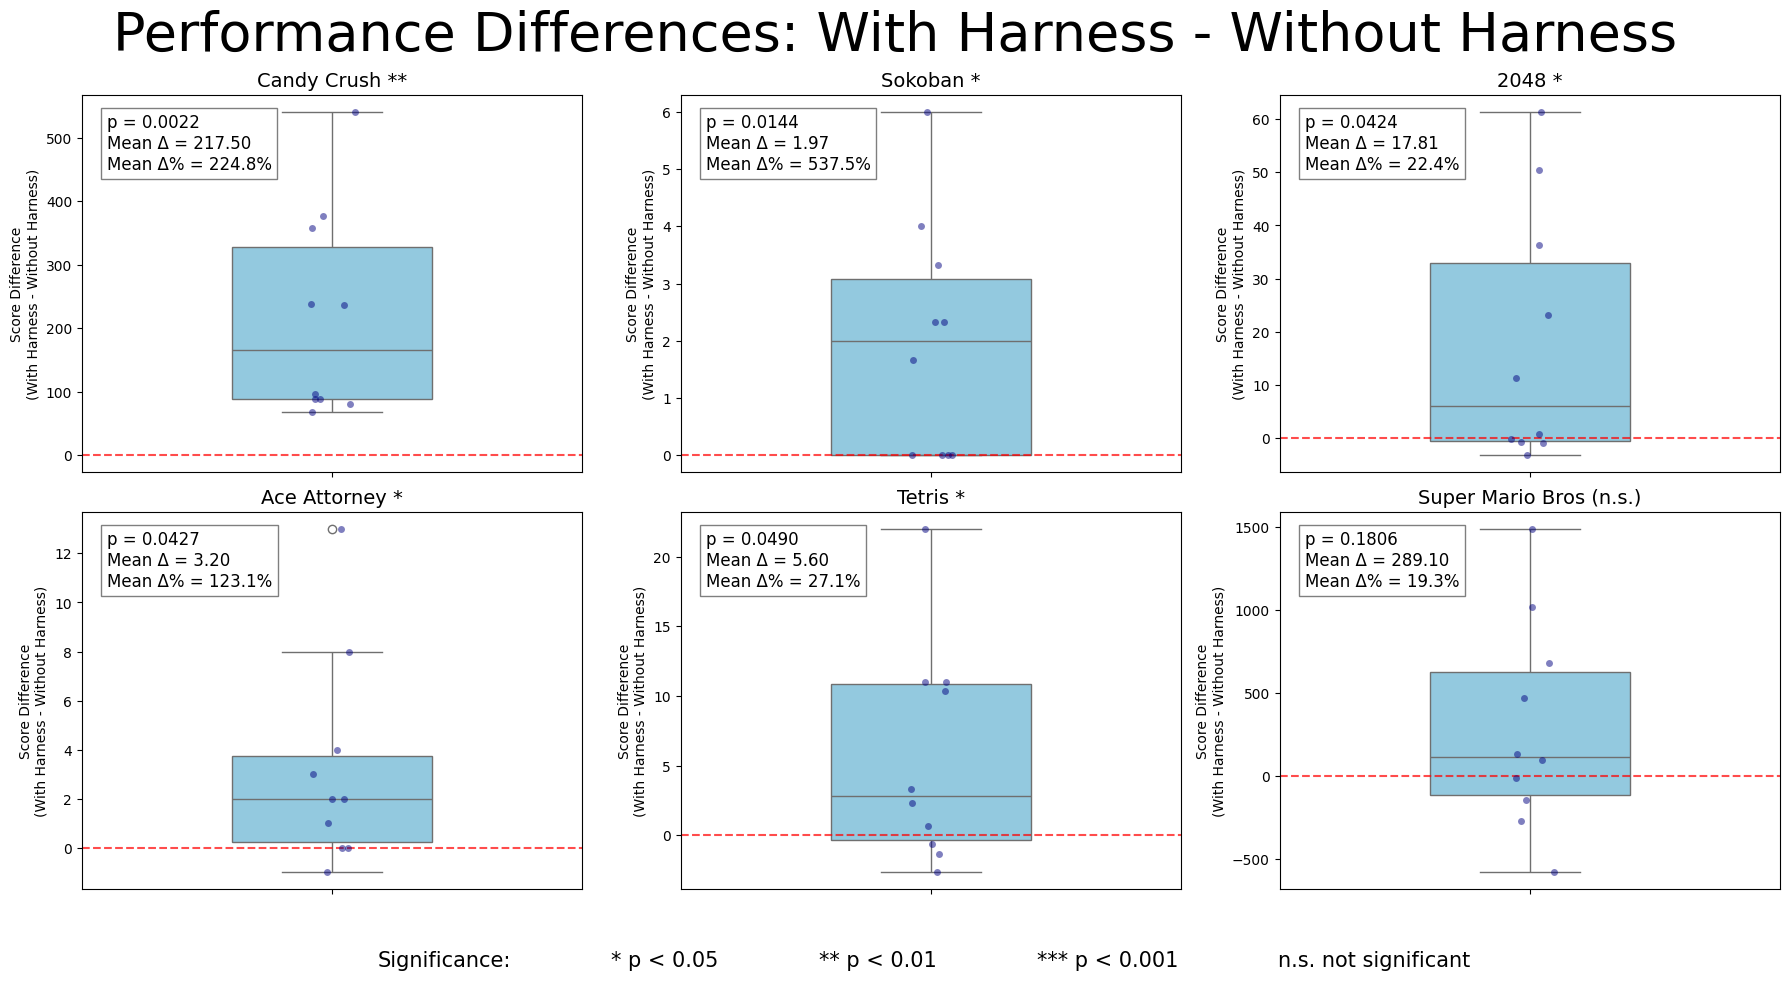

In [6]:
def plot_paired_difference_boxplots(detail_df, ttest_results, figsize=(18, 10)):
    """
    Creates a panel of box plots showing the paired differences (with_harness - without_harness)
    for each game, with significance indicators.
    
    Parameters:
    detail_df (DataFrame): Cleaned detailed performance DataFrame
    ttest_results (DataFrame): Results of the paired t-tests
    figsize (tuple): Figure size (width, height)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from matplotlib.patches import Patch
    
    # Get list of games from t-test results
    games = ttest_results['game'].tolist()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Prepare data for all games
    difference_data = []
    
    # For each game
    for game in games:
        # Collect paired data differences
        for model in detail_df['model_name'].unique():
            model_data = detail_df[detail_df['model_name'] == model]
            
            # Skip if model doesn't have both conditions
            if len(model_data) != 2 or not all(model_data[game].notna()):
                continue
                
            with_harness_data = model_data[model_data['with_harness'] == True][game].iloc[0]
            without_harness_data = model_data[model_data['with_harness'] == False][game].iloc[0]
            
            # Skip if either data is not a list or empty
            if (not isinstance(with_harness_data, list) or not isinstance(without_harness_data, list) or
                len(with_harness_data) == 0 or len(without_harness_data) == 0):
                continue
                
            # Calculate means
            with_mean = np.mean(with_harness_data)
            without_mean = np.mean(without_harness_data)
            
            # Calculate difference and percentage difference
            difference = with_mean - without_mean
            percent_diff = (difference / without_mean * 100) if without_mean != 0 else np.nan
            
            # Store data
            difference_data.append({
                'Game': game,
                'Model': model,
                'Difference': difference,
                'Percent_Difference': percent_diff
            })
    
    # Convert to DataFrame
    df_diff = pd.DataFrame(difference_data)
    
    # For each game
    for i, game in enumerate(games):
        if i >= len(axes):  # Skip if we have more games than plots
            break
            
        ax = axes[i]
        
        # Get t-test result for this game
        test_result = ttest_results[ttest_results['game'] == game].iloc[0]
        
        # Filter data for this game
        game_data = df_diff[df_diff['Game'] == game]
        
        # Skip if no valid data
        if len(game_data) == 0:
            ax.text(0.5, 0.5, f"No paired data for {game}", 
                   ha='center', va='center', fontsize=12)
            ax.set_title(game)
            ax.axis('off')
            continue
            
        # Create box plot
        sns.boxplot(y=game_data['Difference'], ax=ax, color='skyblue', width=0.4)
        
        # Add individual points
        sns.stripplot(y=game_data['Difference'], ax=ax, color='navy', alpha=0.5, jitter=0.05, size=5)
        
        # Add a horizontal line at y=0 (no difference)
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
        # Add significance indicator to title
        if test_result['significant']:
            significance = "***" if test_result['p_value'] < 0.001 else (
                          "**" if test_result['p_value'] < 0.01 else "*")
            ax.set_title(f"{game} {significance}", fontsize=14)
        else:
            ax.set_title(f"{game} (n.s.)", fontsize=14)
            
        # Add p-value and other statistics as text
        stat_text = f"p = {test_result['p_value']:.4f}\n"
        stat_text += f"Mean Δ = {test_result['mean_diff']:.2f}\n"
        
        # Add percent improvement if finite
        if np.isfinite(test_result['percent_improvement']):
            stat_text += f"Mean Δ% = {test_result['percent_improvement']:.1f}%"
        
        ax.text(0.05, 0.95, stat_text, transform=ax.transAxes, 
               fontsize=12, va='top', bbox=dict(facecolor='white', alpha=0.5))
        
        # Improve axes
        ax.set_ylabel('Score Difference\n(With Harness - Without Harness)')
        ax.set_xlabel('')
        
    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    # Add a legend for significance
    legend_elements = [
        Patch(facecolor='none', edgecolor='none', label='Significance:'),
        Patch(facecolor='none', edgecolor='none', label='* p < 0.05'),
        Patch(facecolor='none', edgecolor='none', label='** p < 0.01'),
        Patch(facecolor='none', edgecolor='none', label='*** p < 0.001'),
        Patch(facecolor='none', edgecolor='none', label='n.s. not significant')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, 0), ncol=5, frameon=False, fontsize=15)
    
    # Add a main title
    fig.suptitle("Performance Differences: With Harness - Without Harness", 
                fontsize=39, y=0.98)
    
    # Adjust layout
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    return fig

# Example usage:
fig = plot_paired_difference_boxplots(cleared_detail_performance_df, ttest_results)
plt.savefig('paired_difference_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import numpy as np
import pandas as pd

def calculate_glass_delta(detail_df, random_df):
    """
    Calculate Glass's delta effect size comparing model performance to random baseline.
    Glass's delta = (Model Mean - Random Mean) / Random Standard Deviation
    For the '2048' game, log-transformed scores are used for the model mean calculation.
    """
    # Get list of games
    games = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Calculate random statistics for each game
    random_stats = {}
    for game in games:
        random_scores = random_df[game].iloc[0]  # Get the list of scores
        if random_scores and len(random_scores) > 0:
            # Log transform 2048 random scores for mean calculation consistency if needed
            # However, Glass's Delta uses the *random* SD, so we keep random mean/std based on original scores.
            random_mean = np.mean(random_scores)
            random_std = np.std(random_scores, ddof=1)  # Use sample std
            random_stats[game] = {'mean': random_mean, 'std': random_std}
        else:
            random_stats[game] = {'mean': np.nan, 'std': np.nan}
    
    # Initialize results
    results = []
    
    # Track 2048 scores for later analysis (original scores)
    scores_2048 = {'With Harness': [], 'Without Harness': []}
    
    # For each model and game, calculate Glass's delta
    for _, row in detail_df.iterrows():
        model_name = row['model_name']
        with_harness = row['with_harness']
        harness_label = 'With Harness' if with_harness else 'Without Harness'
        
        for game in games:
            # Skip if no data for this game
            if game not in row or row[game] is None or not isinstance(row[game], list) or len(row[game]) == 0:
                continue
            
            model_scores = row[game]
            
            # Use log-transformed scores for '2048' mean calculation
          
            model_mean = np.mean(model_scores)
            
            # Get random statistics
            random_mean = random_stats[game]['mean']
            random_std = random_stats[game]['std']
            
            # Calculate Glass's delta (only if random_std is not zero and model_mean is valid)
            if not np.isnan(random_std) and random_std > 0 and not np.isnan(model_mean):
                # Note: Glass's delta uses the control group's SD (random_std here)
                # The mean comparison can be between transformed (model) and original (random)
                # or both transformed. Using log(model_mean) vs original random mean here.
                # Be mindful of the interpretation.
                # If you intended to compare log(model_mean) vs log(random_mean),
                # you'd need to calculate log(random_mean) as well.
                # The current calculation compares log(model_scores)_mean to random_scores_mean.
                glass_delta = (model_mean - random_mean) / random_std
            else:
                glass_delta = np.nan
            
            # Add to results
            results.append({
                'model_name': model_name,
                'with_harness': harness_label,
                'game': game,
                'model_mean': model_mean, # This is log mean for 2048
                'random_mean': random_mean,
                'random_std': random_std,
                'glass_delta': glass_delta
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create a pivot table for easier visualization
    # Need to handle potential NaN values if log wasn't applicable
    pivot_df = results_df.pivot_table(
        values='glass_delta',
        index=['model_name', 'with_harness'],
        columns='game'
    )
    
    return results_df, pivot_df, scores_2048

def analyze_harness_effect(glass_results):
    """
    Analyze the effect of harness on Glass's delta.
    Returns summary statistics on harness vs. no harness performance.
    Assumes input glass_results is already filtered.
    """
    # Get model-game pairs that have both harness and no-harness data
    models = glass_results['model_name'].unique()
    games = glass_results['game'].unique()

    harness_better_count = 0
    total_pairs = 0
    harness_positive_count = 0
    no_harness_positive_count = 0
    harness_deltas = []
    no_harness_deltas = []

    # Game-specific analysis
    game_stats = {}

    for game in games:
        game_stats[game] = {
            'harness_deltas': [],
            'no_harness_deltas': [],
            'harness_better': 0,
            'total_pairs': 0
        }

        for model in models:
            # Get data for this model-game pair
            model_game_data = glass_results[(glass_results['model_name'] == model) &
                                            (glass_results['game'] == game)].dropna(subset=['glass_delta']) # Drop pairs where delta couldn't be calculated

            # If we have both harness and no-harness data after dropping NaNs
            if len(model_game_data) == 2:
                try:
                    harness_row = model_game_data[model_game_data['with_harness'] == 'With Harness'].iloc[0]
                    no_harness_row = model_game_data[model_game_data['with_harness'] == 'Without Harness'].iloc[0]

                    harness_delta = harness_row['glass_delta']
                    no_harness_delta = no_harness_row['glass_delta']

                    # Add to overall counts
                    total_pairs += 1
                    if harness_delta > no_harness_delta:
                        harness_better_count += 1

                    if harness_delta > 0:
                        harness_positive_count += 1

                    if no_harness_delta > 0:
                        no_harness_positive_count += 1

                    harness_deltas.append(harness_delta)
                    no_harness_deltas.append(no_harness_delta)

                    # Add to game-specific stats
                    game_stats[game]['harness_deltas'].append(harness_delta)
                    game_stats[game]['no_harness_deltas'].append(no_harness_delta)
                    game_stats[game]['total_pairs'] += 1
                    if harness_delta > no_harness_delta:
                        game_stats[game]['harness_better'] += 1
                except IndexError:
                    # This can happen if one of the harness/no-harness rows had NaN delta and was dropped
                    continue


    # Calculate averages and ratios
    avg_harness = np.mean(harness_deltas) if harness_deltas else np.nan
    avg_no_harness = np.mean(no_harness_deltas) if no_harness_deltas else np.nan
    # Ensure we don't subtract nan
    avg_diff = avg_harness - avg_no_harness if not np.isnan(avg_harness) and not np.isnan(avg_no_harness) else np.nan
    ratio_harness_better = harness_better_count / total_pairs if total_pairs > 0 else np.nan

    # Calculate game-specific averages and ratios
    for game in list(game_stats.keys()): # Iterate over copy of keys
         stats = game_stats[game]
         if stats['total_pairs'] > 0:
             stats['avg_harness'] = np.mean(stats['harness_deltas'])
             stats['avg_no_harness'] = np.mean(stats['no_harness_deltas'])
             # Check for NaN before subtraction
             if not np.isnan(stats['avg_harness']) and not np.isnan(stats['avg_no_harness']):
                 stats['avg_diff'] = stats['avg_harness'] - stats['avg_no_harness']
             else:
                 stats['avg_diff'] = np.nan
             stats['ratio_harness_better'] = stats['harness_better'] / stats['total_pairs']
         else:
             # Remove game from stats if no valid pairs were found
             del game_stats[game]


    # Create summary dictionary
    summary = {
        'total_model_game_pairs': total_pairs,
        'harness_better_count': harness_better_count,
        'harness_better_ratio': ratio_harness_better,
        'harness_positive_count': harness_positive_count,
        'no_harness_positive_count': no_harness_positive_count,
        'avg_glass_delta_harness': avg_harness,
        'avg_glass_delta_no_harness': avg_no_harness,
        'avg_glass_delta_difference': avg_diff,
        'game_stats': game_stats
    }

    return summary

def print_glass_delta_summary(glass_results, summary, scores_2048=None):
    """
    Print a detailed summary of the Glass's delta analysis results.
    Assumes input glass_results is already filtered.
    """
    print("\n===== GLASS'S DELTA ANALYSIS SUMMARY =====")
    print(f"Total model-game pairs analyzed (excluding Ace Attorney, Sokoban): {summary['total_model_game_pairs']}")
    print(f"Pairs where harness outperforms no harness: {summary['harness_better_count']} ({summary['harness_better_ratio']:.2%})")
    print(f"Models with positive Glass's delta (harness): {summary['harness_positive_count']}")
    print(f"Models with positive Glass's delta (no harness): {summary['no_harness_positive_count']}")
    print(f"Average Glass's delta (harness): {summary['avg_glass_delta_harness']:.4f}")
    print(f"Average Glass's delta (no harness): {summary['avg_glass_delta_no_harness']:.4f}")
    print(f"Average difference (harness - no harness): {summary['avg_glass_delta_difference']:.4f}")

    # Game-specific analysis
    print("\n--- Game-specific Analysis (excluding Ace Attorney, Sokoban) ---")
    # Sort games for consistent output
    sorted_games = sorted(summary['game_stats'].keys())
    for game in sorted_games:
        stats = summary['game_stats'][game]
        # Ensure there are pairs before printing stats for the game
        if stats['total_pairs'] > 0:
            print(f"{game}:")
            print(f"  Avg Glass's delta (harness): {stats.get('avg_harness', np.nan):.4f}")
            print(f"  Avg Glass's delta (no harness): {stats.get('avg_no_harness', np.nan):.4f}")
            print(f"  Difference: {stats.get('avg_diff', np.nan):.4f}")
            print(f"  Harness better ratio: {stats.get('ratio_harness_better', np.nan):.2%}")
            print(f"  Pairs compared: {stats['total_pairs']}")


    print("\n=========================================")
    
    # Optional: Print analysis of 2048 original scores if needed
    # if scores_2048:
    #     print("\n--- 2048 Original Score Analysis ---")
    #     # Add analysis based on the original scores stored in scores_2048


# -------- Usage Example Modification --------
# Assuming cleared_detail_performance_df and random_df are loaded

# Calculate initial results
# This function now correctly defines random_stats internally
glass_results_all, glass_pivot_all, scores_2048 = calculate_glass_delta(cleared_detail_performance_df, random_df)

# Filter out games with zero or NaN random standard deviation directly from the results DataFrame
# Find unique games and their corresponding random_std
game_stds = glass_results_all[['game', 'random_std']].drop_duplicates()
zero_std_games = set(game_stds[ (game_stds['random_std'] == 0) | (game_stds['random_std'].isna()) ]['game'])

print(f"Games with zero or NaN random standard deviation found in results: {zero_std_games}")
# Combine with the explicitly requested games to drop
games_to_drop = zero_std_games.union({'Ace Attorney', 'Sokoban'})
print(f"Dropping games: {games_to_drop}")


# Filter the results DataFrame
glass_results_filtered = glass_results_all[~glass_results_all['game'].isin(games_to_drop)].copy() # Use .copy() to avoid SettingWithCopyWarning

# Analyze the filtered results
summary_filtered = analyze_harness_effect(glass_results_filtered)

# Print the summary using filtered results
# Make sure scores_2048 is passed if you intend to use it inside the print function later
print_glass_delta_summary(glass_results_filtered, summary_filtered, scores_2048=scores_2048) # Pass scores_2048 here


# You might also want to update the pivot table based on filtered results
if not glass_results_filtered.empty:
    glass_pivot_filtered = glass_results_filtered.pivot_table(
        values='glass_delta',
        index=['model_name', 'with_harness'],
        columns='game',
        dropna=False # Keep columns even if all values are NaN after filtering
    )
    print("\nFiltered Pivot Table:")
    print(glass_pivot_filtered)
else:
    print("\nFiltered results DataFrame is empty. Cannot create pivot table.")

# print(glass_pivot_filtered)


Games with zero or NaN random standard deviation found in results: {'Sokoban', 'Ace Attorney'}
Dropping games: {'Sokoban', 'Ace Attorney'}

===== GLASS'S DELTA ANALYSIS SUMMARY =====
Total model-game pairs analyzed (excluding Ace Attorney, Sokoban): 40
Pairs where harness outperforms no harness: 29 (72.50%)
Models with positive Glass's delta (harness): 38
Models with positive Glass's delta (no harness): 26
Average Glass's delta (harness): 3.3344
Average Glass's delta (no harness): 0.7498
Average difference (harness - no harness): 2.5846

--- Game-specific Analysis (excluding Ace Attorney, Sokoban) ---
2048:
  Avg Glass's delta (harness): 1.7475
  Avg Glass's delta (no harness): -0.5268
  Difference: 2.2743
  Harness better ratio: 60.00%
  Pairs compared: 10
Candy Crush:
  Avg Glass's delta (harness): 3.7443
  Avg Glass's delta (no harness): -0.4812
  Difference: 4.2255
  Harness better ratio: 100.00%
  Pairs compared: 10
Super Mario Bros:
  Avg Glass's delta (harness): 1.7131
  Avg Gla

## Hypothesis 2: harness can better distinguish models
1. prove value range is different under two settings (fine-grained, hedge)
2. prove harness distribution is more consistent
    1) variance difference is smaller under harness than that under no harness 
    2) harness has few overlapping than no harness had with random distribution

In [8]:
# Effect Size Measurement
import numpy as np
import pandas as pd
import scipy.stats as st
from cliffs_delta import cliffs_delta  # pip install cliffs_delta

def improved_harness_effect_size_analysis(detail_df=None):
    """
    Corrected version of harness effect size analysis that properly handles paired statistics
    by first collapsing each model's multiple trials to a single summary statistic.
    """
    # Clean data if not already cleaned
    if detail_df is None:
        detail_df = clean_detail_performance_df(create_detail_performance_df())
    
    # Prepare data for analysis
    games = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    models = detail_df['model_name'].unique()
    
    results = []
    
    for game in games:
        # Lists to store paired model-level summaries
        with_harness_means = []
        without_harness_means = []
        model_names = []
        
        for model in models:
            # Get data for this model and game
            model_data = detail_df[detail_df['model_name'] == model]
            
            # Check if we have both with and without harness data
            if len(model_data) != 2:
                continue
            
            # Get scores with and without harness
            with_harness = model_data[model_data['with_harness'] == True][game].iloc[0]
            without_harness = model_data[model_data['with_harness'] == False][game].iloc[0]
            
            # Skip if either is None or empty
            if (with_harness is None or without_harness is None or 
                len(with_harness) == 0 or len(without_harness) == 0):
                continue
            
            # Convert to numpy arrays
            with_harness = np.array(with_harness)
            without_harness = np.array(without_harness)
            
            # Calculate mean for each condition
            with_mean = np.mean(with_harness)
            without_mean = np.mean(without_harness)
            
            # Store the model-level means
            with_harness_means.append(with_mean)
            without_harness_means.append(without_mean)
            model_names.append(model)
        
        # Skip if no valid model pairs
        if not with_harness_means:
            continue
        
        # Convert to numpy arrays
        with_harness_means = np.array(with_harness_means)
        without_harness_means = np.array(without_harness_means)
        
        # Calculate the paired differences
        paired_diff = with_harness_means - without_harness_means
        
        # Conduct paired statistics if we have enough data
        if len(paired_diff) > 1:
            # Calculate mean difference
            mean_diff = np.mean(paired_diff)
            
            # Paired Cohen's d_z
            if np.std(paired_diff, ddof=1) > 0:
                cohen_dz = mean_diff / np.std(paired_diff, ddof=1)
                
                # Hedges' g correction for paired data
                n = len(paired_diff)
                J = 1 - (3 / (4*n-9)) if n >= 3 else 1  # Corrected Hedges adjustment
                hedges_g = cohen_dz * J
                
                # Calculate Glass' Delta (using no-harness as control)
                glass_delta = mean_diff / np.std(without_harness_means, ddof=1) if np.std(without_harness_means, ddof=1) > 0 else None
                
                # Calculate Cliff's delta on the model-level means
                try:
                    delta, _ = cliffs_delta(with_harness_means, without_harness_means)
                    a12 = (delta + 1) / 2  # Vargha-Delaney A12
                except:
                    delta = None
                    a12 = None
                
                # Bootstrap confidence intervals for the model-level statistics
                def boot_ci(stat_func, X, Y, B=5000, seed=0):
                    """Calculate bootstrap confidence interval for a paired statistic"""
                    if len(X) < 2:
                        return [None, None]
                    
                    rng = np.random.default_rng(seed)
                    stats = []
                    n = len(X)
                    
                    for _ in range(B):
                        try:
                            # Resample at the model level to respect pairing
                            idx = rng.choice(range(n), n, replace=True)
                            x_boot = X[idx]
                            y_boot = Y[idx]
                            
                            # Calculate statistic on the resampled data
                            stat = stat_func(x_boot, y_boot)
                            if not np.isnan(stat):
                                stats.append(stat)
                        except:
                            continue
                    
                    if len(stats) > 50:  # Ensure enough bootstrap samples
                        return np.percentile(stats, [2.5, 97.5])
                    return [None, None]
                
                # Calculate Hedges' g confidence interval
                hedges_g_func = lambda x, y: np.mean(x - y) / np.std(x - y, ddof=1) * (1 - 3/(4*len(x)-9)) if len(x) >= 3 and np.std(x - y, ddof=1) > 0 else np.nan
                ci_g = boot_ci(hedges_g_func, with_harness_means, without_harness_means)
                
                # Common Language Effect Size based on model means
                cles = sum(wh > nh for wh in with_harness_means for nh in without_harness_means) / (len(with_harness_means) * len(without_harness_means))
                
                # For each model, calculate and store the results
                for i, model in enumerate(model_names):
                    results.append({
                        'model': model,
                        'game': game,
                        'n_models': len(model_names),
                        'mean_with_harness': with_harness_means[i],
                        'mean_without_harness': without_harness_means[i],
                        'model_diff': paired_diff[i],
                        'mean_diff': mean_diff,  # Average diff across all models
                        'cohen_dz': cohen_dz,
                        'hedges_g': hedges_g,
                        'hedges_g_ci_low': ci_g[0],
                        'hedges_g_ci_high': ci_g[1],
                        'glass_delta': glass_delta,
                        'cliffs_delta': delta,
                        'vargha_delaney_a12': a12,
                        'cles': cles
                    })
    
    # Create dataframe with results
    results_df = pd.DataFrame(results)
    
    # Add interpretation columns
    if not results_df.empty:
        def cohen_interp(d):
            if d is None:
                return None
            if abs(d) < 0.2:
                return "negligible"
            elif abs(d) < 0.5:
                return "small"
            elif abs(d) < 0.8:
                return "medium"
            else:
                return "large"
            
        def cliff_interp(d):
            if d is None:
                return None
            if abs(d) < 0.147:
                return "negligible"
            elif abs(d) < 0.33:
                return "small"
            elif abs(d) < 0.474:
                return "medium"
            else:
                return "large"
        
        results_df['cohen_interpretation'] = results_df['cohen_dz'].apply(cohen_interp)
        results_df['cliff_interpretation'] = results_df['cliffs_delta'].apply(cliff_interp)
        
    return results_df

def analyze_effect_size_results(results_df=None):
    """
    Analyze the effect size results and print comprehensive insights.
    
    Parameters:
    results_df (DataFrame): The results dataframe from improved_harness_effect_size_analysis
    
    Returns:
    dict: A dictionary containing various analysis results
    """
    if results_df is None or results_df.empty:
        return "Insufficient data for analysis"
    
    insights = {}
    
    # 1. Overall effect summary
    overall_hedges = results_df['hedges_g'].mean()
    overall_cliff = results_df['cliffs_delta'].mean()
    overall_a12 = results_df['vargha_delaney_a12'].mean()
    
    hedges_interp = "negligible" if abs(overall_hedges) < 0.2 else "small" if abs(overall_hedges) < 0.5 else "medium" if abs(overall_hedges) < 0.8 else "large"
    cliff_interp = "negligible" if abs(overall_cliff) < 0.147 else "small" if abs(overall_cliff) < 0.33 else "medium" if abs(overall_cliff) < 0.474 else "large"
    
    insights['overall'] = {
        'hedges_g': overall_hedges,
        'hedges_interpretation': hedges_interp,
        'cliffs_delta': overall_cliff,
        'cliff_interpretation': cliff_interp,
        'vargha_delaney_a12': overall_a12,
    }
    
    # 2. Per-game analysis
    game_analysis = {}
    for game, game_df in results_df.groupby('game'):
        avg_hedges = game_df['hedges_g'].mean()
        avg_cliff = game_df['cliffs_delta'].mean()
        avg_a12 = game_df['vargha_delaney_a12'].mean()
        mean_diff = game_df['mean_diff'].mean()
        percent_improvement = (game_df['mean_with_harness'] / game_df['mean_without_harness'] - 1).mean() * 100
        
        # Interpretation
        hedges_interp = "negligible" if abs(avg_hedges) < 0.2 else "small" if abs(avg_hedges) < 0.5 else "medium" if abs(avg_hedges) < 0.8 else "large"
        cliff_interp = "negligible" if abs(avg_cliff) < 0.147 else "small" if abs(avg_cliff) < 0.33 else "medium" if abs(avg_cliff) < 0.474 else "large"
        
        game_analysis[game] = {
            'mean_diff': mean_diff,
            'percent_improvement': percent_improvement,
            'hedges_g': avg_hedges,
            'hedges_interpretation': hedges_interp,
            'cliffs_delta': avg_cliff,
            'cliff_interpretation': cliff_interp,
            'vargha_delaney_a12': avg_a12,
            'sample_size': len(game_df)
        }
    
    insights['game_analysis'] = game_analysis
    
    # 3. Model analysis - which models benefit most from harness
    model_analysis = {}
    for model, model_df in results_df.groupby('model'):
        avg_hedges = model_df['hedges_g'].mean()
        avg_cliff = model_df['cliffs_delta'].mean()
        count_large_effect = sum((model_df['cohen_interpretation'] == 'large') | (model_df['cliff_interpretation'] == 'large'))
        games_improved = model_df[model_df['mean_diff'] > 0]['game'].tolist()
        
        model_analysis[model] = {
            'avg_hedges_g': avg_hedges,
            'avg_cliffs_delta': avg_cliff,
            'count_large_effects': count_large_effect,
            'games_improved': games_improved,
            'percent_games_improved': len(games_improved) / len(model_df) * 100
        }
    
    insights['model_analysis'] = model_analysis
    
    # 4. Find patterns across effect sizes
    effect_consistency = {}
    for game in results_df['game'].unique():
        game_df = results_df[results_df['game'] == game]
        consistent_direction = (game_df['mean_diff'] > 0).all() or (game_df['mean_diff'] < 0).all()
        consistent_magnitude = game_df['cohen_interpretation'].nunique() <= 2  # At most 2 different effect sizes
        
        effect_consistency[game] = {
            'consistent_direction': consistent_direction,
            'consistent_magnitude': consistent_magnitude,
            'all_positive': (game_df['mean_diff'] > 0).all(),
            'all_negative': (game_df['mean_diff'] < 0).all()
        }
    
    insights['effect_consistency'] = effect_consistency
    
    # Print comprehensive summary
    print("\n===== EFFECT SIZE ANALYSIS SUMMARY =====\n")
    
    print(f"OVERALL HARNESS EFFECT:")
    print(f"- Average Hedges' g: {overall_hedges:.2f} ({hedges_interp} effect)")
    print(f"- Average Cliff's δ: {overall_cliff:.2f} ({cliff_interp} effect)")
    print(f"- Probability of harness outperforming no-harness: {overall_a12*100:.1f}%")
    
    print("\nEFFECT BY GAME:")
    for game, stats in game_analysis.items():
        print(f"\n{game}:")
        print(f"- Raw score improvement: {stats['mean_diff']:.2f} points")
        print(f"- Percent improvement: {stats['percent_improvement']:.1f}%")
        print(f"- Hedges' g: {stats['hedges_g']:.2f} ({stats['hedges_interpretation']} effect)")
        print(f"- Cliff's δ: {stats['cliffs_delta']:.2f} ({stats['cliff_interpretation']} effect)")
        print(f"- Probability of harness outperforming no-harness: {stats['vargha_delaney_a12']*100:.1f}%")
        print(f"- Based on {stats['sample_size']} model comparisons")
        
        if stats['hedges_interpretation'] in ['medium', 'large'] and stats['cliff_interpretation'] in ['medium', 'large']:
            print(f"  → Strong evidence for substantial harness benefit in {game}")
        elif stats['hedges_interpretation'] in ['negligible', 'small'] and stats['cliff_interpretation'] in ['negligible', 'small']:
            print(f"  → Limited evidence for harness benefit in {game}")
        else:
            print(f"  → Mixed evidence for harness benefit in {game}")
    
    print("\nMODELS BENEFITING MOST FROM HARNESS:")
    sorted_models = sorted(model_analysis.items(), key=lambda x: x[1]['avg_hedges_g'], reverse=True)
    for model, stats in sorted_models[:3]:  # Top 3 models
        print(f"\n{model}:")
        print(f"- Average Hedges' g: {stats['avg_hedges_g']:.2f}")
        print(f"- Average Cliff's δ: {stats['avg_cliffs_delta']:.2f}")
        print(f"- Games with large effects: {stats['count_large_effects']}")
        print(f"- Percent of games improved: {stats['percent_games_improved']:.1f}%")
        print(f"- Games improved: {', '.join(stats['games_improved'])}")
    
    print("\nKEY INSIGHTS:")
    
    # Count games with consistent positive effects
    consistent_positive = sum(stats['all_positive'] for game, stats in effect_consistency.items())
    total_games = len(effect_consistency)
    
    print(f"- {consistent_positive}/{total_games} games show consistent positive effects across all models")
    
    # Identify best combination
    best_game = max(game_analysis.items(), key=lambda x: x[1]['hedges_g'])[0]
    best_model = max(model_analysis.items(), key=lambda x: x[1]['avg_hedges_g'])[0]
    
    print(f"- Largest harness benefit observed in the game '{best_game}'")
    print(f"- Model '{best_model}' shows the greatest overall benefit from harness use")
    
    # General conclusion
    if overall_hedges > 0.5 and overall_cliff > 0.33:
        print("\nCONCLUSION: Harness provides substantial, consistent performance improvements across games and models")
    elif overall_hedges > 0.2 and overall_cliff > 0.147:
        print("\nCONCLUSION: Harness provides modest but noticeable performance improvements across games and models")
    else:
        print("\nCONCLUSION: Harness provides limited performance improvements overall, with benefits varying by game and model")
    
    return insights



effect_size_df = improved_harness_effect_size_analysis(cleared_detail_performance_df)
analyze_effect_size_results(effect_size_df)


===== EFFECT SIZE ANALYSIS SUMMARY =====

OVERALL HARNESS EFFECT:
- Average Hedges' g: 0.75 (medium effect)
- Average Cliff's δ: 0.43 (medium effect)
- Probability of harness outperforming no-harness: 71.7%

EFFECT BY GAME:

2048:
- Raw score improvement: 17.81 points
- Percent improvement: 30.8%
- Hedges' g: 0.67 (medium effect)
- Cliff's δ: 0.30 (small effect)
- Probability of harness outperforming no-harness: 65.0%
- Based on 10 model comparisons
  → Mixed evidence for harness benefit in 2048

Ace Attorney:
- Raw score improvement: 3.20 points
- Percent improvement: inf%
- Hedges' g: 0.67 (medium effect)
- Cliff's δ: 0.32 (small effect)
- Probability of harness outperforming no-harness: 66.0%
- Based on 10 model comparisons
  → Mixed evidence for harness benefit in Ace Attorney

Candy Crush:
- Raw score improvement: 217.50 points
- Percent improvement: 263.9%
- Hedges' g: 1.21 (large effect)
- Cliff's δ: 0.87 (large effect)
- Probability of harness outperforming no-harness: 93.5%
-

{'overall': {'hedges_g': 0.7469367871080127,
  'hedges_interpretation': 'medium',
  'cliffs_delta': 0.43333333333333335,
  'cliff_interpretation': 'medium',
  'vargha_delaney_a12': 0.7166666666666665},
 'game_analysis': {'2048': {'mean_diff': 17.81302699149196,
   'percent_improvement': 30.805620787754727,
   'hedges_g': 0.674817626070273,
   'hedges_interpretation': 'medium',
   'cliffs_delta': 0.29999999999999993,
   'cliff_interpretation': 'small',
   'vargha_delaney_a12': 0.6500000000000001,
   'sample_size': 10},
  'Ace Attorney': {'mean_diff': 3.2,
   'percent_improvement': inf,
   'hedges_g': 0.6738099259542912,
   'hedges_interpretation': 'medium',
   'cliffs_delta': 0.31999999999999995,
   'cliff_interpretation': 'small',
   'vargha_delaney_a12': 0.66,
   'sample_size': 10},
  'Candy Crush': {'mean_diff': 217.5,
   'percent_improvement': 263.9338569556803,
   'hedges_g': 1.205434823569982,
   'hedges_interpretation': 'large',
   'cliffs_delta': 0.8699999999999999,
   'cliff_in

In [9]:
import numpy as np
import pandas as pd
import scipy.stats as st
import warnings
from itertools import product

def analyze_cv_paired_differences(detail_df=None):
    """
    Analyze differences in Coefficient of Variation (CV) between harness and no-harness conditions
    using Wilcoxon signed-rank test with proper statistical methods.
    
    Parameters:
    detail_df (DataFrame): The cleaned detail performance DataFrame
    
    Returns:
    dict: Results of CV analysis by game
    """
    # Constants
    EPSILON = 1e-9  # Small constant to prevent division by zero
    
    if detail_df is None:
        detail_df = clean_detail_performance_df(create_detail_performance_df())
    
    # Get list of all games
    games = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    results = {}
    
    for game in games:
        # Store model-level paired differences
        model_names = []
        with_cvs = []
        without_cvs = []
        cv_diffs = []  # without - with (positive = harness reduces variability)
        
        # Calculate CV for each model
        for model in detail_df['model_name'].unique():
            model_data = detail_df[detail_df['model_name'] == model]
            
            # Skip if we don't have both conditions
            if model_data['with_harness'].nunique() < 2:
                continue
            
            try:
                # Aggregate all rows per condition (crucial fix)
                grp = model_data.groupby('with_harness')[game].apply(
                    lambda s: np.concatenate([np.asarray(x, dtype=float) for x in s if x is not None])
                )
                
                # Check if both conditions exist
                if True not in grp.index or False not in grp.index:
                    continue
                    
                with_scores = grp.loc[True]
                without_scores = grp.loc[False]
                
                # Skip if either condition doesn't have enough scores
                if len(with_scores) < 2 or len(without_scores) < 2:
                    continue
                
                # Calculate means and check for near-zero means
                with_mean = np.mean(with_scores)
                without_mean = np.mean(without_scores)
                
                if abs(with_mean) < EPSILON or abs(without_mean) < EPSILON:
                    continue  # Skip cases with near-zero means
                
                # Calculate coefficient of variation (CV = std/mean)
                # No abs() on means unless we expect negative values
                with_std = np.std(with_scores, ddof=1)  # Use n-1 denominator
                without_std = np.std(without_scores, ddof=1)
                
                with_cv = with_std / with_mean
                without_cv = without_std / without_mean
                
                # Calculate paired difference
                cv_diff = without_cv - with_cv  # Positive = harness reduces variability
                
                # Store results
                model_names.append(model)
                with_cvs.append(with_cv)
                without_cvs.append(without_cv)
                cv_diffs.append(cv_diff)
                
            except (IndexError, ValueError) as e:
                # Skip problematic data
                continue
        
        # Skip if we don't have enough models for analysis
        if len(model_names) < 5:
            results[game] = {
                'status': 'insufficient_data',
                'n_models': len(model_names)
            }
            continue
        
        # Convert to numpy arrays
        with_cvs = np.array(with_cvs)
        without_cvs = np.array(without_cvs)
        cv_diffs = np.array(cv_diffs)
        
        # Check for normality with Shapiro-Wilk test
        _, sw_p = st.shapiro(cv_diffs)
        is_normal = sw_p > 0.20  # Using recommended threshold
        
        # Perform Wilcoxon signed-rank test
        try:
            with warnings.catch_warnings(record=True) as w:
                w_stat, p_value = st.wilcoxon(cv_diffs, mode="exact")  # Use exact p-value for small samples
                test_result = {
                    'statistic': w_stat,
                    'p_value': p_value,
                    'warnings': len(w) > 0
                }
                
                # Check for zero differences which affect exact p-value calculation
                if np.any(np.isclose(cv_diffs, 0)):
                    test_result['note'] = 'Zeros present; Wilcoxon p is normal approximation'
                
                # Calculate effect size r for Wilcoxon
                test_result['effect_size_r'] = w_stat / np.sqrt(len(cv_diffs))
                
        except Exception as e:
            test_result = {'error': str(e)}
        
        # Perform paired t-test if data appears normal
        t_test_result = {}
        if is_normal:
            try:
                t_stat, t_p = st.ttest_rel(without_cvs, with_cvs)
                cohen_dz = np.mean(cv_diffs) / np.std(cv_diffs, ddof=1)
                
                # Hedges correction for paired data
                n = len(cv_diffs)
                J = 1 - (3 / (4*n-9)) if n >= 3 else 1
                hedges_g = cohen_dz * J
                
                t_test_result = {
                    't_statistic': t_stat,
                    'p_value': t_p,
                    'cohen_dz': cohen_dz,
                    'hedges_g': hedges_g
                }
            except Exception as e:
                t_test_result = {'error': str(e)}
        
        # Store results
        results[game] = {
            'n_models': len(model_names),
            'with_harness_cv_mean': np.mean(with_cvs),
            'without_harness_cv_mean': np.mean(without_cvs),
            'cv_diff_mean': np.mean(cv_diffs),
            'cv_diff_median': np.median(cv_diffs),
            'percent_reduced': np.mean(cv_diffs > 0) * 100,
            'is_normal': is_normal,
            'shapiro_p': sw_p,
            'wilcoxon_test': test_result,
            't_test': t_test_result if is_normal else {'performed': False, 'reason': 'non-normal data'}
        }
    
    return results

def print_cv_results(results):
    """
    Print CV analysis results in a readable format
    """
    print("\n===== COEFFICIENT OF VARIATION ANALYSIS =====\n")
    
    # Print results by game
    for game, data in sorted(results.items()):
        print(f"\n{game}:")
        
        if 'status' in data:
            print(f"  Insufficient data for analysis (only {data['n_models']} models)")
            continue
        
        print(f"- CV: {data['with_harness_cv_mean']:.3f} (with harness) vs {data['without_harness_cv_mean']:.3f} (without harness)")
        print(f"- Mean difference (without - with): {data['cv_diff_mean']:.3f}")
        print(f"- Median difference: {data['cv_diff_median']:.3f}")
        print(f"- {data['percent_reduced']:.1f}% of models showed reduced variability with harness")
        
        # Normality check
        print(f"- Normality check: {'PASSED' if data['is_normal'] else 'FAILED'} (Shapiro-Wilk p = {data['shapiro_p']:.4f})")
        
        # Wilcoxon test results
        test = data['wilcoxon_test']
        if 'error' in test:
            print(f"- Wilcoxon test failed: {test['error']}")
        else:
            print(f"- Wilcoxon signed-rank test: W={test['statistic']:.2f}, p={test['p_value']:.4f}, r={test.get('effect_size_r', 'NA'):.3f}")
            
            if test.get('warnings', False) or 'note' in test:
                note = test.get('note', 'possible computational issues')
                print(f"  (Note: {note})")
            
            if test['p_value'] < 0.05:
                direction = "REDUCES" if data['cv_diff_mean'] > 0 else "INCREASES"
                print(f"  → Harness SIGNIFICANTLY {direction} variability")
            else:
                direction = "reduces" if data['cv_diff_mean'] > 0 else "increases"
                print(f"  → Harness {direction} variability (not statistically significant)")
        
        # T-test results if appropriate
        if data['is_normal'] and 'error' not in data['t_test']:
            t_test = data['t_test']
            print(f"- Paired t-test: t={t_test['t_statistic']:.2f}, p={t_test['p_value']:.4f}")
            print(f"  Effect size: Cohen's d_z = {t_test['cohen_dz']:.3f}, Hedges' g = {t_test['hedges_g']:.3f}")
    
    # Count games with reduced and increased variability
    games_analyzed = sum(1 for g, d in results.items() if 'status' not in d)
    reduced_var = sum(1 for g, d in results.items() if 'status' not in d and d['cv_diff_mean'] > 0)
    significant = sum(1 for g, d in results.items() 
                    if 'status' not in d and 
                    'p_value' in d['wilcoxon_test'] and 
                    d['wilcoxon_test']['p_value'] < 0.05)
    
    print("\nSUMMARY:")
    print(f"- Analyzed {games_analyzed} games")
    print(f"- {reduced_var}/{games_analyzed} games showed reduced variability with harness")
    print(f"- {significant}/{games_analyzed} games showed statistically significant differences")
# Example of how to run the analysis
variance_results = analyze_cv_paired_differences(cleared_detail_performance_df)
print_cv_results(variance_results)


===== COEFFICIENT OF VARIATION ANALYSIS =====


2048:
- CV: 0.044 (with harness) vs 0.171 (without harness)
- Mean difference (without - with): 0.127
- Median difference: 0.148
- 75.0% of models showed reduced variability with harness
- Normality check: FAILED (Shapiro-Wilk p = 0.1635)
- Wilcoxon signed-rank test: W=3.00, p=0.0391, r=1.061
  → Harness SIGNIFICANTLY REDUCES variability

Ace Attorney:
  Insufficient data for analysis (only 0 models)

Candy Crush:
- CV: 0.275 (with harness) vs 0.774 (without harness)
- Mean difference (without - with): 0.499
- Median difference: 0.498
- 100.0% of models showed reduced variability with harness
- Normality check: PASSED (Shapiro-Wilk p = 0.9299)
- Wilcoxon signed-rank test: W=0.00, p=0.0078, r=0.000
  → Harness SIGNIFICANTLY REDUCES variability
- Paired t-test: t=4.32, p=0.0035
  Effect size: Cohen's d_z = 1.528, Hedges' g = 1.329

Sokoban:
  Insufficient data for analysis (only 2 models)

Super Mario Bros:
- CV: 0.342 (with harness) vs 0.

In [10]:
def calculate_cv_table_with_log_transform(detail_df, random_df, epsilon=1e-8):
    """
    Calculate Coefficient of Variation (CV) for each model, game, condition, and random performance.
    Applies log transformation to 2048 scores before calculating CV due to their exponential nature.
    
    Parameters:
    detail_df (DataFrame): Detailed performance dataframe
    random_df (DataFrame): Random performance dataframe
    epsilon (float): Small constant to avoid division by zero for near-zero means
    
    Returns both a detailed DataFrame and a pivot table for visualization.
    """
    # Get list of games
    games = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Calculate CV for random performance
    random_cv = {}
    for game in games:
        random_scores = random_df[game].iloc[0]  # Get the list of scores
        if random_scores and len(random_scores) > 0:
            random_scores = np.array(random_scores)
            
            # Apply log transformation to 2048 scores
            if game == '2048':
                # Add small constant to avoid log(0)
                random_scores = np.log(random_scores + 1)
                
            random_mean = np.mean(random_scores)
            random_std = np.std(random_scores, ddof=1)  # Use sample std
            
            # Handle zero or near-zero mean
            if abs(random_mean) < epsilon:
                random_mean = epsilon if random_mean >= 0 else -epsilon
                
            random_cv[game] = random_std / random_mean
        else:
            random_cv[game] = np.nan
    
    # Initialize results
    results = []
    
    # Add random performance to results
    for game, cv in random_cv.items():
        results.append({
            'model_name': 'Random',
            'condition': 'Random',
            'game': game,
            'cv': cv,
            'transformed': game == '2048'
        })
    
    # For each model and game, calculate CV
    for _, row in detail_df.iterrows():
        model_name = row['model_name']
        condition = 'With Harness' if row['with_harness'] else 'Without Harness'
        
        for game in games:
            # Skip if no data for this game
            if game not in row or row[game] is None or not isinstance(row[game], list) or len(row[game]) == 0:
                continue
            
            # Get model scores
            model_scores = np.array(row[game])
            
            # Apply log transformation to 2048 scores
            if game == '2048':
                # Add small constant to avoid log(0)
                model_scores = np.log(model_scores + 1)
            
            # Skip if only one score (can't calculate std)
            if len(model_scores) <= 1:
                continue
                
            model_mean = np.mean(model_scores)
            model_std = np.std(model_scores, ddof=1)  # Use sample std
            
            # Handle zero or near-zero mean
            if abs(model_mean) < epsilon:
                model_mean = epsilon if model_mean >= 0 else -epsilon
            
            # Calculate CV
            cv = model_std / model_mean
            
            # Add to results
            results.append({
                'model_name': model_name,
                'condition': condition,
                'game': game,
                'cv': cv,
                'transformed': game == '2048'
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create a pivot table for easier visualization
    pivot_df = results_df.pivot_table(
        values='cv',
        index=['model_name', 'condition'],
        columns='game'
    )
    
    return results_df, pivot_df

# Calculate coefficient of variation with log transform for 2048
cv_log_results, cv_log_pivot = calculate_cv_table_with_log_transform(cleared_detail_performance_df, random_df)

# Display the pivot table with formatted values (as percentages)
formatted_cv_log_pivot = (cv_log_pivot * 100).round(3)

# Add note about transformation
print("Note: CV values for 2048 were calculated after applying log transformation to scores")
print("      Small epsilon value was added to handle near-zero means")
formatted_cv_log_pivot

Note: CV values for 2048 were calculated after applying log transformation to scores
      Small epsilon value was added to handle near-zero means


game                                                     2048  Ace Attorney  \
model_name                             condition                              
Random                                 Random           1.683           0.0   
claude-3-5-sonnet-20241022             With Harness     1.116           NaN   
                                       Without Harness  6.808           NaN   
claude-3-7-sonnet-20250219 (thinking)  With Harness     0.578           NaN   
                                       Without Harness  1.326           NaN   
gemini-2.5-flash-preview-04-17         With Harness     1.037           NaN   
                                       Without Harness  0.666           NaN   
gemini-2.5-pro-preview-05-06           With Harness     1.029           NaN   
                                       Without Harness  0.665           NaN   
gpt-4.1-2025-04-14                     With Harness     1.377           NaN   
                                       Without Harness  3.809           NaN   
gpt-4o-2024-11-20                      With Harness     0.691           NaN   
                                       Without Harness  5.344           NaN   
llama-4-maverick-17b-128e-instruct-fp8 With Harness     0.748           NaN   
                                       Without Harness  6.513           NaN   
o1-2024-12-17                          With Harness       NaN           NaN   
o3-2025-04-16                          With Harness       NaN           NaN   
o4-mini-2025-04-16                     With Harness     0.842           NaN   
                                       Without Harness  7.288           NaN   

game                                                    Candy Crush  Sokoban  \
model_name                             condition                               
Random                                 Random                44.183    0.000   
claude-3-5-sonnet-20241022             With Harness          50.372    0.000   
                                       Without Harness      106.371    0.000   
claude-3-7-sonnet-20250219 (thinking)  With Harness          11.090   65.465   
                                       Without Harness       54.694    0.000   
gemini-2.5-flash-preview-04-17         With Harness          19.581   91.652   
                                       Without Harness       36.978    0.000   
gemini-2.5-pro-preview-05-06           With Harness           1.635   13.323   
                                       Without Harness       36.599    0.000   
gpt-4.1-2025-04-14                     With Harness          15.763    0.000   
                                       Without Harness      119.047    0.000   
gpt-4o-2024-11-20                      With Harness          36.249    0.000   
                                       Without Harness       92.509    0.000   
llama-4-maverick-17b-128e-instruct-fp8 With Harness          44.459    0.000   
                                       Without Harness      128.055    0.000   
o1-2024-12-17                          With Harness             NaN   24.744   
o3-2025-04-16                          With Harness             NaN   35.355   
o4-mini-2025-04-16                     With Harness          40.634   21.651   
                                       Without Harness       44.866   43.301   

game                                                    Super Mario Bros  \
model_name                             condition                           
Random                                 Random                     41.995   
claude-3-5-sonnet-20241022             With Harness               38.184   
                                       Without Harness             1.409   
claude-3-7-sonnet-20250219 (thinking)  With Harness               46.546   
                                       Without Harness            11.341   
gemini-2.5-flash-preview-04-17         With Harness               17.210   
                                       Without Harn

In [11]:
# Drop the Ace Attorney column and specific model rows
formatted_cv_log_pivot_filtered = formatted_cv_log_pivot.drop(columns=['Ace Attorney', 'Sokoban']).drop(index=[
    ('o1-2024-12-17', 'With Harness'),
    ('o3-2025-04-16', 'With Harness')
])
formatted_cv_log_pivot_filtered

game                                                     2048  Candy Crush  \
model_name                             condition                             
Random                                 Random           1.683       44.183   
claude-3-5-sonnet-20241022             With Harness     1.116       50.372   
                                       Without Harness  6.808      106.371   
claude-3-7-sonnet-20250219 (thinking)  With Harness     0.578       11.090   
                                       Without Harness  1.326       54.694   
gemini-2.5-flash-preview-04-17         With Harness     1.037       19.581   
                                       Without Harness  0.666       36.978   
gemini-2.5-pro-preview-05-06           With Harness     1.029        1.635   
                                       Without Harness  0.665       36.599   
gpt-4.1-2025-04-14                     With Harness     1.377       15.763   
                                       Without Harness  3.809      119.047   
gpt-4o-2024-11-20                      With Harness     0.691       36.249   
                                       Without Harness  5.344       92.509   
llama-4-maverick-17b-128e-instruct-fp8 With Harness     0.748       44.459   
                                       Without Harness  6.513      128.055   
o4-mini-2025-04-16                     With Harness     0.842       40.634   
                                       Without Harness  7.288       44.866   

game                                                    Super Mario Bros  \
model_name                             condition                           
Random                                 Random                     41.995   
claude-3-5-sonnet-20241022             With Harness               38.184   
                                       Without Harness             1.409   
claude-3-7-sonnet-20250219 (thinking)  With Harness               46.546   
                                       Without Harness            11.341   
gemini-2.5-flash-preview-04-17         With Harness               17.210   
                                       Without Harness            17.034   
gemini-2.5-pro-preview-05-06           With Harness               13.573   
                                       Without Harness            43.228   
gpt-4.1-2025-04-14                     With Harness               83.636   
                                       Without Harness            51.144   
gpt-4o-2024-11-20                      With Harness               25.797   
                                       Without Harness            63.796   
llama-4-maverick-17b-128e-instruct-fp8 With Harness               37.835   
                                       Without Harness            58.857   
o4-mini-2025-04-16                     With Harness               11.116   
                                       Without Harness            13.210   

game                                                    Tetris  
model_name                             condition                
Random                                 Random           17.535  
claude-3-5-sonnet-20241022             With Harness      7.873  
                                       Without Harness  20.405  
claude-3-7-sonnet-20250219 (thinking)  With Harness     14.139  
                                       Without Harness   0.000  
gemini-2.5-flash-preview-04-17         With Harness     19.681  
                                       Without Harness  24.119  
gemini-2.5-pro-preview-05-06           With Harness      2.474  
                                       Without Harness  24.771  
gpt-4.1-2025-04-14                     With Harness      4.225  
                                       Without Harness  13.323  
gpt-4o-2024-11-20                      With Harness     25.754  
                                       Without Harness  14.193  
llama-4-maverick-17b-128e-instruct-fp8 With Harness     14.783  
                                

In [12]:
def generate_cv_summary(cv_pivot_df):
    """
    Generate a summary of coefficient of variation (CV) comparisons:
    1. Ratio of models where CV with harness is smaller than random
    2. Ratio of models where CV with harness is smaller than without harness
    
    Parameters:
    cv_pivot_df (DataFrame): Pivot table with CV values for each model, condition, and game
    
    Returns:
    dict: Summary statistics by game and overall
    """
    import pandas as pd
    import numpy as np
    
    # Initialize results dictionary
    summary = {
        'by_game': {},
        'overall': {}
    }
    
    # Get list of games (columns)
    games = cv_pivot_df.columns.tolist()
    
    # Get random CV values (if available)
    random_cv = {}
    for game in games:
        if ('Random', 'Random') in cv_pivot_df.index:
            random_cv[game] = cv_pivot_df.loc[('Random', 'Random'), game]
        else:
            random_cv[game] = np.nan
    
    # Initialize counters for overall statistics
    total_with_harness_models = 0
    total_with_harness_smaller_than_random = 0
    total_paired_models = 0  # models with both with/without harness
    total_with_harness_smaller_than_without = 0
    
    # For each game
    for game in games:
        harness_smaller_than_random_count = 0
        harness_smaller_than_random_models = 0
        harness_smaller_than_without_count = 0
        harness_smaller_than_without_models = 0
        
        # Get list of unique model names (excluding 'Random')
        model_names = set([model for model, _ in cv_pivot_df.index if model != 'Random'])
        
        # For each model
        for model in model_names:
            # Check if model has with_harness condition
            if (model, 'With Harness') in cv_pivot_df.index:
                with_harness_cv = cv_pivot_df.loc[(model, 'With Harness'), game]
                
                # Skip if NaN
                if pd.isna(with_harness_cv):
                    continue
                
                harness_smaller_than_random_models += 1
                total_with_harness_models += 1
                
                # Compare with random
                if not pd.isna(random_cv[game]) and with_harness_cv < random_cv[game]:
                    harness_smaller_than_random_count += 1
                    total_with_harness_smaller_than_random += 1
                
                # Check if model also has without_harness condition
                if (model, 'Without Harness') in cv_pivot_df.index:
                    without_harness_cv = cv_pivot_df.loc[(model, 'Without Harness'), game]
                    
                    # Skip if NaN
                    if pd.isna(without_harness_cv):
                        continue
                    
                    harness_smaller_than_without_models += 1
                    total_paired_models += 1
                    
                    # Compare with without harness
                    if with_harness_cv < without_harness_cv:
                        harness_smaller_than_without_count += 1
                        total_with_harness_smaller_than_without += 1
        
        # Calculate percentages for this game
        if harness_smaller_than_random_models > 0:
            vs_random_percent = (harness_smaller_than_random_count / harness_smaller_than_random_models) * 100
        else:
            vs_random_percent = np.nan
            
        if harness_smaller_than_without_models > 0:
            vs_without_percent = (harness_smaller_than_without_count / harness_smaller_than_without_models) * 100
        else:
            vs_without_percent = np.nan
        
        # Store results for this game
        summary['by_game'][game] = {
            'harness_smaller_than_random_count': harness_smaller_than_random_count,
            'harness_smaller_than_random_total': harness_smaller_than_random_models,
            'harness_smaller_than_random_percent': vs_random_percent,
            'harness_smaller_than_without_count': harness_smaller_than_without_count,
            'harness_smaller_than_without_total': harness_smaller_than_without_models,
            'harness_smaller_than_without_percent': vs_without_percent
        }
    
    # Calculate overall percentages
    if total_with_harness_models > 0:
        overall_vs_random_percent = (total_with_harness_smaller_than_random / total_with_harness_models) * 100
    else:
        overall_vs_random_percent = np.nan
        
    if total_paired_models > 0:
        overall_vs_without_percent = (total_with_harness_smaller_than_without / total_paired_models) * 100
    else:
        overall_vs_without_percent = np.nan
    
    # Store overall results
    summary['overall'] = {
        'harness_smaller_than_random_count': total_with_harness_smaller_than_random,
        'harness_smaller_than_random_total': total_with_harness_models,
        'harness_smaller_than_random_percent': overall_vs_random_percent,
        'harness_smaller_than_without_count': total_with_harness_smaller_than_without,
        'harness_smaller_than_without_total': total_paired_models,
        'harness_smaller_than_without_percent': overall_vs_without_percent
    }
    
    return summary

def print_cv_summary(summary):
    """
    Print the CV summary in a readable format
    """
    print("\n===== COEFFICIENT OF VARIATION SUMMARY =====\n")
    
    # Print per-game summary
    print("RESULTS BY GAME:")
    for game, stats in summary['by_game'].items():
        print(f"\n{game}:")
        
        # With harness vs Random
        if not np.isnan(stats['harness_smaller_than_random_percent']):
            print(f"  - Models with CV(harness) < CV(random): {stats['harness_smaller_than_random_count']}/{stats['harness_smaller_than_random_total']} ({stats['harness_smaller_than_random_percent']:.1f}%)")
        else:
            print(f"  - Models with CV(harness) < CV(random): No data")
            
        # With harness vs Without harness
        if not np.isnan(stats['harness_smaller_than_without_percent']):
            print(f"  - Models with CV(with harness) < CV(without harness): {stats['harness_smaller_than_without_count']}/{stats['harness_smaller_than_without_total']} ({stats['harness_smaller_than_without_percent']:.1f}%)")
        else:
            print(f"  - Models with CV(with harness) < CV(without harness): No data")
    
    # Print overall summary
    print("\nOVERALL RESULTS:")
    
    # With harness vs Random
    if not np.isnan(summary['overall']['harness_smaller_than_random_percent']):
        print(f"  - Models with CV(harness) < CV(random): {summary['overall']['harness_smaller_than_random_count']}/{summary['overall']['harness_smaller_than_random_total']} ({summary['overall']['harness_smaller_than_random_percent']:.1f}%)")
    else:
        print(f"  - Models with CV(harness) < CV(random): No data")
        
    # With harness vs Without harness
    if not np.isnan(summary['overall']['harness_smaller_than_without_percent']):
        print(f"  - Models with CV(with harness) < CV(without harness): {summary['overall']['harness_smaller_than_without_count']}/{summary['overall']['harness_smaller_than_without_total']} ({summary['overall']['harness_smaller_than_without_percent']:.1f}%)")
    else:
        print(f"  - Models with CV(with harness) < CV(without harness): No data")
    
    # Summary conclusion
    print("\nCONCLUSION:")
    if summary['overall']['harness_smaller_than_without_percent'] > 75:
        print("  The harness condition substantially reduces performance variability across models and games.")
    elif summary['overall']['harness_smaller_than_without_percent'] > 50:
        print("  The harness condition moderately reduces performance variability across models and games.")
    elif summary['overall']['harness_smaller_than_without_percent'] < 25:
        print("  The harness condition tends to increase performance variability across models and games.")
    else:
        print("  The harness condition has mixed effects on performance variability across models and games.")

# Generate and print the summary
cv_summary = generate_cv_summary(formatted_cv_log_pivot_filtered)
print_cv_summary(cv_summary)


===== COEFFICIENT OF VARIATION SUMMARY =====

RESULTS BY GAME:

2048:
  - Models with CV(harness) < CV(random): 8/8 (100.0%)
  - Models with CV(with harness) < CV(without harness): 6/8 (75.0%)

Candy Crush:
  - Models with CV(harness) < CV(random): 6/8 (75.0%)
  - Models with CV(with harness) < CV(without harness): 8/8 (100.0%)

Super Mario Bros:
  - Models with CV(harness) < CV(random): 6/8 (75.0%)
  - Models with CV(with harness) < CV(without harness): 4/8 (50.0%)

Tetris:
  - Models with CV(harness) < CV(random): 5/8 (62.5%)
  - Models with CV(with harness) < CV(without harness): 4/8 (50.0%)

OVERALL RESULTS:
  - Models with CV(harness) < CV(random): 25/32 (78.1%)
  - Models with CV(with harness) < CV(without harness): 22/32 (68.8%)

CONCLUSION:
  The harness condition moderately reduces performance variability across models and games.


In [13]:
def calculate_variance_ratio(detail_df, random_df):
    """
    Calculate the ratio of model variance to random variance for F-scores.
    Variance Ratio = Model Variance / Random Variance
    
    Parameters:
    detail_df (DataFrame): DataFrame with model performance data with columns for model_name, with_harness, and game scores
    random_df (DataFrame): DataFrame with random baseline performance data
    
    Returns:
    tuple: (results_df, pivot_df) with variance ratios
    """
    import numpy as np
    import pandas as pd
    
    # Get list of games (assuming they are columns other than model_name and with_harness)
    games = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Calculate random variance for each game
    random_var = {}
    for game in games:
        if game in random_df.columns:
            random_scores = random_df[game].iloc[0]  # Get the list of scores
            if random_scores and len(random_scores) > 1:
                random_variance = np.var(random_scores, ddof=1)  # Use sample variance
                random_var[game] = random_variance
            else:
                random_var[game] = np.nan
        else:
            random_var[game] = np.nan
    
    # Initialize results
    results = []
    
    # For each model and game, calculate variance ratio
    for _, row in detail_df.iterrows():
        model_name = row['model_name']
        with_harness = row['with_harness']
        harness_label = 'With Harness' if with_harness else 'Without Harness'
        
        for game in games:
            # Skip if no data for this game
            if game not in row or row[game] is None or not isinstance(row[game], list) or len(row[game]) <= 1:
                continue
            
            model_scores = row[game]
            model_variance = np.var(model_scores, ddof=1)  # Use sample variance
            
            # Get random variance
            if game in random_var and not np.isnan(random_var[game]) and random_var[game] > 0:
                variance_ratio = model_variance / random_var[game]
            else:
                variance_ratio = np.nan
            
            # Add to results
            results.append({
                'model_name': model_name,
                'with_harness': harness_label,
                'game': game,
                'model_variance': model_variance,
                'random_variance': random_var[game],
                'variance_ratio': variance_ratio
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create a pivot table for easier visualization
    pivot_df = results_df.pivot_table(
        values='variance_ratio',
        index=['model_name', 'with_harness'],
        columns='game'
    )
    
    return results_df, pivot_df

def analyze_variance_ratios(var_results):
    """
    Analyze the effect of harness on variance ratios.
    Returns summary statistics on harness vs. no harness variance ratios.
    """
    import numpy as np
    
    # Get model-game pairs that have both harness and no-harness data
    models = var_results['model_name'].unique()
    games = var_results['game'].unique()

    harness_smaller_count = 0
    total_pairs = 0
    harness_ratios = []
    no_harness_ratios = []
    
    # Game-specific analysis
    game_stats = {}

    for game in games:
        game_stats[game] = {
            'harness_ratios': [],
            'no_harness_ratios': [],
            'harness_smaller': 0,
            'total_pairs': 0
        }

        for model in models:
            # Get data for this model-game pair
            model_game_data = var_results[(var_results['model_name'] == model) &
                                        (var_results['game'] == game)].dropna(subset=['variance_ratio'])

            # If we have both harness and no-harness data after dropping NaNs
            if len(model_game_data) == 2:
                try:
                    harness_row = model_game_data[model_game_data['with_harness'] == 'With Harness'].iloc[0]
                    no_harness_row = model_game_data[model_game_data['with_harness'] == 'Without Harness'].iloc[0]

                    harness_ratio = harness_row['variance_ratio']
                    no_harness_ratio = no_harness_row['variance_ratio']

                    # Add to overall counts
                    total_pairs += 1
                    if harness_ratio < no_harness_ratio:
                        harness_smaller_count += 1

                    harness_ratios.append(harness_ratio)
                    no_harness_ratios.append(no_harness_ratio)

                    # Add to game-specific stats
                    game_stats[game]['harness_ratios'].append(harness_ratio)
                    game_stats[game]['no_harness_ratios'].append(no_harness_ratio)
                    game_stats[game]['total_pairs'] += 1
                    if harness_ratio < no_harness_ratio:
                        game_stats[game]['harness_smaller'] += 1
                except IndexError:
                    continue

    # Calculate averages and ratios
    avg_harness = np.mean(harness_ratios) if harness_ratios else np.nan
    avg_no_harness = np.mean(no_harness_ratios) if no_harness_ratios else np.nan
    avg_diff = avg_no_harness - avg_harness if not np.isnan(avg_harness) and not np.isnan(avg_no_harness) else np.nan
    ratio_harness_smaller = harness_smaller_count / total_pairs if total_pairs > 0 else np.nan

    # Calculate game-specific averages and ratios
    for game in list(game_stats.keys()):
        stats = game_stats[game]
        if stats['total_pairs'] > 0:
            stats['avg_harness'] = np.mean(stats['harness_ratios'])
            stats['avg_no_harness'] = np.mean(stats['no_harness_ratios'])
            if not np.isnan(stats['avg_harness']) and not np.isnan(stats['avg_no_harness']):
                stats['avg_diff'] = stats['avg_no_harness'] - stats['avg_harness']
            else:
                stats['avg_diff'] = np.nan
            stats['ratio_harness_smaller'] = stats['harness_smaller'] / stats['total_pairs']
        else:
            del game_stats[game]

    # Create summary dictionary
    summary = {
        'total_model_game_pairs': total_pairs,
        'harness_smaller_count': harness_smaller_count,
        'harness_smaller_ratio': ratio_harness_smaller,
        'avg_variance_ratio_harness': avg_harness,
        'avg_variance_ratio_no_harness': avg_no_harness,
        'avg_variance_ratio_difference': avg_diff,
        'game_stats': game_stats
    }

    return summary

def print_variance_ratio_summary(summary):
    """
    Print a detailed summary of the variance ratio analysis results.
    """
    import numpy as np
    
    print("\n===== VARIANCE RATIO ANALYSIS SUMMARY =====")
    print(f"Total model-game pairs analyzed: {summary['total_model_game_pairs']}")
    print(f"Pairs where harness has smaller variance ratio: {summary['harness_smaller_count']} ({summary['harness_smaller_ratio']:.2%})")
    print(f"Average variance ratio (harness): {summary['avg_variance_ratio_harness']:.4f}")
    print(f"Average variance ratio (no harness): {summary['avg_variance_ratio_no_harness']:.4f}")
    print(f"Average difference (no harness - harness): {summary['avg_variance_ratio_difference']:.4f}")

    # Game-specific analysis
    print("\n--- Game-specific Analysis ---")
    sorted_games = sorted(summary['game_stats'].keys())
    for game in sorted_games:
        stats = summary['game_stats'][game]
        if stats['total_pairs'] > 0:
            print(f"{game}:")
            print(f"  Avg variance ratio (harness): {stats.get('avg_harness', np.nan):.4f}")
            print(f"  Avg variance ratio (no harness): {stats.get('avg_no_harness', np.nan):.4f}")
            print(f"  Difference: {stats.get('avg_diff', np.nan):.4f}")
            print(f"  Harness smaller ratio: {stats.get('ratio_harness_smaller', np.nan):.2%}")
            print(f"  Pairs compared: {stats['total_pairs']}")

    print("\n--- Interpretation ---")
    if summary['avg_variance_ratio_harness'] < summary['avg_variance_ratio_no_harness']:
        print("  Models with harness show lower variance compared to random than models without harness.")
    elif summary['avg_variance_ratio_harness'] > summary['avg_variance_ratio_no_harness']:
        print("  Models without harness show lower variance compared to random than models with harness.")
    else:
        print("  Models with and without harness show similar variance patterns compared to random.")
        
    if summary['avg_variance_ratio_harness'] < 1:
        print("  On average, models with harness have lower variance than random baseline.")
    else:
        print("  On average, models with harness have higher variance than random baseline.")
        
    if summary['avg_variance_ratio_no_harness'] < 1:
        print("  On average, models without harness have lower variance than random baseline.")
    else:
        print("  On average, models without harness have higher variance than random baseline.")

    print("\n===========================================")

# Example usage:
var_results, var_pivot = calculate_variance_ratio(cleared_detail_performance_df, random_df)
summary = analyze_variance_ratios(var_results)
print_variance_ratio_summary(summary)


===== VARIANCE RATIO ANALYSIS SUMMARY =====
Total model-game pairs analyzed: 32
Pairs where harness has smaller variance ratio: 18 (56.25%)
Average variance ratio (harness): 2.6300
Average variance ratio (no harness): 2.2631
Average difference (no harness - harness): -0.3668

--- Game-specific Analysis ---
2048:
  Avg variance ratio (harness): 0.4164
  Avg variance ratio (no harness): 3.7782
  Difference: 3.3618
  Harness smaller ratio: 75.00%
  Pairs compared: 8
Candy Crush:
  Avg variance ratio (harness): 2.6530
  Avg variance ratio (no harness): 1.5207
  Difference: -1.1322
  Harness smaller ratio: 50.00%
  Pairs compared: 8
Super Mario Bros:
  Avg variance ratio (harness): 3.3075
  Avg variance ratio (no harness): 1.4593
  Difference: -1.8483
  Harness smaller ratio: 50.00%
  Pairs compared: 8
Tetris:
  Avg variance ratio (harness): 4.1429
  Avg variance ratio (no harness): 2.2943
  Difference: -1.8486
  Harness smaller ratio: 50.00%
  Pairs compared: 8

--- Interpretation ---
  M

In [14]:
def create_variance_dataframe(detail_df, random_df):
    """
    Create a comprehensive dataframe of variances for all data points including random baseline.
    
    Parameters:
    detail_df (DataFrame): DataFrame with model performance data with columns for model_name, with_harness, and game scores
    random_df (DataFrame): DataFrame with random baseline performance data
    
    Returns:
    DataFrame: Comprehensive dataframe with variances for all data points
    """
    import numpy as np
    import pandas as pd
    
    # Get list of games (assuming they are columns other than model_name and with_harness)
    games = [col for col in detail_df.columns if col not in ['model_name', 'with_harness']]
    
    # Initialize results list
    results = []
    
    # Calculate random variance for each game
    for game in games:
        if game in random_df.columns:
            random_scores = random_df[game].iloc[0]  # Get the list of scores
            if random_scores and len(random_scores) > 1:
                random_variance = np.var(random_scores, ddof=1)  # Use sample variance
                random_mean = np.mean(random_scores)
                random_std = np.std(random_scores, ddof=1)
                
                # Add random baseline to results
                results.append({
                    'model_name': 'Random Baseline',
                    'with_harness': 'N/A',
                    'game': game,
                    'variance': random_variance,
                    'mean': random_mean,
                    'std_dev': random_std,
                    'num_samples': len(random_scores),
                    'scores': random_scores
                })
    
    # For each model and game, calculate variance
    for _, row in detail_df.iterrows():
        model_name = row['model_name']
        with_harness = row['with_harness']
        harness_label = 'With Harness' if with_harness else 'Without Harness'
        
        for game in games:
            # Skip if no data for this game
            if game not in row or row[game] is None or not isinstance(row[game], list):
                continue
            
            model_scores = row[game]
            
            if len(model_scores) > 1:
                model_variance = np.var(model_scores, ddof=1)  # Use sample variance
                model_mean = np.mean(model_scores)
                model_std = np.std(model_scores, ddof=1)
                
                # Add to results
                results.append({
                    'model_name': model_name,
                    'with_harness': harness_label,
                    'game': game,
                    'variance': model_variance,
                    'mean': model_mean,
                    'std_dev': model_std,
                    'num_samples': len(model_scores),
                    'scores': model_scores
                })
    
    # Convert to DataFrame
    variance_df = pd.DataFrame(results)
    
    # Sort for better readability
    variance_df = variance_df.sort_values(['game', 'model_name', 'with_harness'])
    
    return variance_df

variance_df= create_variance_dataframe(detail_performance_df, random_df)

In [15]:
variance_df['model_name'].unique()

array(['Random', 'Random Baseline', 'claude-3-5-sonnet-20241022',
       'claude-3-7-sonnet-20250219 (thinking)', 'deepseek-r1',
       'gemini-2.5-flash-preview-04-17', 'gemini-2.5-pro-preview-05-06',
       'gpt-4.1-2025-04-14', 'gpt-4o-2024-11-20',
       'grok-3-mini-beta (thinking)',
       'llama-4-maverick-17b-128e-instruct-fp8', 'o1-mini-2024-09-12',
       'o4-mini-2025-04-16', 'o1-2024-12-17', 'o3-2025-04-16'],
      dtype=object)

In [16]:
variance_df[variance_df['model_name'] == "Random Baseline"]

,model_name,with_harness,game,variance,mean,std_dev,num_samples,scores
3,Random Baseline,N/A,2048,61.345814,100.441249,7.832357,30,"[98.45490050944376, 100.98032082960528, 106.07..."
5,Random Baseline,N/A,Ace Attorney,0.000000,0.000000,0.000000,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Random Baseline,N/A,Candy Crush,2649.500000,116.500000,51.473294,30,"[59, 120, 13, 108, 195, 207, 93, 102, 115, 178..."
0,Random Baseline,N/A,Sokoban,0.000000,0.000000,0.000000,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Random Baseline,N/A,Super Mario Bros,171788.240230,986.966667,414.473449,30,"[1255, 722, 1660, 1495, 665, 1246, 293, 694, 8..."
2,Random Baseline,N/A,Tetris,3.178161,10.166667,1.782740,30,"[11, 10, 8, 9, 13, 13, 12, 10, 9, 10, 9, 9, 7,..."


In [17]:
variance_df[variance_df['game'] == '2048']

,model_name,with_harness,game,variance,mean,std_dev,num_samples,scores
103,Random,Without Harness,2048,4.782105,102.510191,2.186803,3,"[104.75733430966399, 100.38918989292301, 102.3..."
3,Random Baseline,N/A,2048,61.345814,100.441249,7.832357,30,"[98.45490050944376, 100.98032082960528, 106.07..."
14,claude-3-5-sonnet-20241022,With Harness,2048,33.533034,108.212931,5.790771,3,"[104.00879436282183, 114.81799431665752, 105.8..."
9,claude-3-5-sonnet-20241022,Without Harness,2048,268.894894,57.786495,16.398015,3,"[75.54588851677637, 43.219280948873624, 54.594..."
24,claude-3-7-sonnet-20250219 (thinking),With Harness,2048,9.832235,113.348234,3.135639,3,"[113.21928094887362, 116.54636028527968, 110.2..."
19,claude-3-7-sonnet-20250219 (thinking),Without Harness,2048,51.484166,114.167054,7.175247,3,"[106.40244936222345, 120.5528243550119, 115.54..."
28,deepseek-r1,With Harness,2048,147.932702,105.242752,12.162759,3,"[94.51211111832329, 102.76124405274238, 118.45..."
38,gemini-2.5-flash-preview-04-17,With Harness,2048,27.980660,106.607117,5.289675,3,"[103.48728154231077, 103.61943773735241, 112.7..."
33,gemini-2.5-flash-preview-04-17,Without Harness,2048,11.599678,107.360972,3.405830,3,"[111.21533517340032, 104.75733430966399, 106.1..."
48,gemini-2.5-pro-preview-05-06,With Harness,2048,34.286586,117.266371,5.855475,3,"[123.71776644337925, 112.28818690495882, 115.7..."


In [18]:
log_performance_df

,model_name,with_harness,Sokoban,Super Mario Bros,Tetris,2048,Candy Crush,Ace Attorney
0,claude-3-5-sonnet-20241022,False,0.000000,1540.000000,12.333333,57.786495,17.000000,1.0
1,claude-3-5-sonnet-20241022,True,0.000000,1267.666667,14.666667,108.212931,106.000000,2.0
2,claude-3-7-sonnet-20250219 (thinking),False,0.000000,1430.000000,13.000000,114.167054,126.333333,3.0
3,claude-3-7-sonnet-20250219 (thinking),True,2.333333,1418.666667,16.333333,113.348234,484.000000,7.0
4,deepseek-r1,False,NaN,NaN,NaN,NaN,NaN,NaN
5,deepseek-r1,True,1.333333,NaN,14.333333,105.242752,447.333333,0.0
6,gemini-2.5-flash-preview-04-17,False,0.000000,1540.666667,19.000000,107.360972,97.666667,1.0
7,gemini-2.5-flash-preview-04-17,True,1.666667,1395.000000,16.333333,106.607117,334.666667,4.0
8,gemini-2.5-pro-preview-05-06,False,1.000000,1025.333333,12.333333,120.479610,177.333333,8.0
9,gemini-2.5-pro-preview-05-06,True,4.333333,1498.333333,23.333333,117.266371,416.333333,7.0


In [19]:
np.mean(np.array(random_df['2048'][0]))

100.44124935062722

In [20]:
import json
import numpy as np
import pandas as pd

def calculate_log2_transformed_scores_and_variance():
    # Load the JSON file
    with open('module_performance.json', 'r') as f:
        data = json.load(f)
    
    # Prepare data for log2*10 transformed scores DataFrame
    score_rows = []
    variance_rows = []
    
    for model in data['models']:
        score_row = {'model_name': model['name']}
        variance_row = {'model_name': model['name']}
        
        # Process Sokoban data
        sokoban_data = model['scores']['sokoban']
        if 'memory' in sokoban_data and isinstance(sokoban_data['memory'], list):
            variance_row['sokoban_memory_mean'] = np.mean(sokoban_data['memory'])
            variance_row['sokoban_memory_std'] = np.std(sokoban_data['memory'], ddof=1)
        
        if 'vision' in sokoban_data and isinstance(sokoban_data['vision'], list):
            variance_row['sokoban_vision_mean'] = np.mean(sokoban_data['vision'])
            variance_row['sokoban_vision_std'] = np.std(sokoban_data['vision'], ddof=1)
        
        # Get 2048 data
        game_2048_data = model['scores']['2048']
        
        # Process memory scores
        if 'memory' in game_2048_data and isinstance(game_2048_data['memory'], list):
            # Transform scores using log2*10
            log2_scores = [np.log2(score) * 10 if score > 0 else 0 for score in game_2048_data['memory']]
            variance_row['2048_memory_mean'] = np.mean(log2_scores)
            score_row['2048_memory_log2x10'] = log2_scores
            variance_row['2048_memory_log2x10_std'] = np.std(log2_scores, ddof=1)
        
        # Process vision scores
        if 'vision' in game_2048_data and isinstance(game_2048_data['vision'], list):
            # Transform scores using log2*10
            log2_scores = [np.log2(score) * 10 if score > 0 else 0 for score in game_2048_data['vision']]
            variance_row['2048_vision_mean'] = np.mean(log2_scores)
            score_row['2048_vision_log2x10'] = log2_scores
            variance_row['2048_vision_log2x10_std'] = np.std(log2_scores, ddof=1)
        
        score_rows.append(score_row)
        variance_rows.append(variance_row)
    
    # Create DataFrames
    scores_df = pd.DataFrame(score_rows)
    variance_df = pd.DataFrame(variance_rows)
    
    return scores_df, variance_df

# Example usage:
module_transformed_scores_df, module_variance_df = calculate_log2_transformed_scores_and_variance()

In [21]:
module_transformed_scores_df

,model_name,2048_memory_log2x10,2048_vision_log2x10
0,o4-mini 2025-04-16,"[124.47083226209654, 115.58420713268663, 105.1...","[124.25215903299383, 114.1574176829009, 112.52..."
1,Gemini-2.5 Pro (03-25),"[116.22051819456375, 127.21953612801386, 110.6...","[112.99208018387279, 123.96604781181858, 115.3..."
2,Claude-3.7 Sonnet Thinking,"[103.70687406807218, 112.96916206879288, 104.7...","[112.69126679149417, 117.74787059601174, 115.4..."
3,llama-4-maverick,"[100.38918989292301, 100.16808287686555, 93.75...","[58.07354922057604, 89.30737337562887, 73.5755..."
4,claude-3-5-sonnet-20241022,"[104.22064766172812, 100.92757140919852, 102.4...","[76.14709844115208, 65.84962500721156, 57.0043..."
5,gpt-4o,"[114.30452551665532, 103.44295907915816, 103.2...","[73.92317422778761, 67.54887502163469, 78.3289..."


In [22]:
module_variance_df

,model_name,sokoban_memory_mean,sokoban_memory_std,sokoban_vision_mean,sokoban_vision_std,2048_memory_mean,2048_memory_log2x10_std,2048_vision_mean,2048_vision_log2x10_std
0,o4-mini 2025-04-16,1.333333,0.57735,5.333333,2.081666,115.070679,9.667152,116.978744,6.351518
1,Gemini-2.5 Pro (03-25),1.000000,0.00000,6.000000,2.000000,118.015671,8.450524,117.436961,5.776238
2,Claude-3.7 Sonnet Thinking,0.333333,0.57735,0.666667,0.577350,107.144457,5.071613,115.309119,2.533055
3,llama-4-maverick,0.000000,0.00000,0.000000,0.000000,98.102556,3.770703,73.652148,15.617053
4,claude-3-5-sonnet-20241022,0.000000,0.00000,0.000000,0.000000,102.542498,1.647448,66.333707,9.580527
5,gpt-4o,0.000000,0.00000,0.000000,0.000000,107.003926,6.323135,73.266983,5.419887


## Hypothesis Test Rethink:
Harness performance scores are good for benchmark.
1. harness could better show model ability.
    1) harness is better than random
        a. Glass Delta Effect Size for harness and not harness - a table
    2) harness is better than no harness
        a.paired-sample t test
2. harness make model performance more consistent
    1) harness variance is smaller than random, no harness
        a. coefficient of variance - a table